<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/5450_Project_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing New Libraries

In [171]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00


In [88]:
!pip install mplcursors

In [89]:
!pip install ydata_profiling

# Importing Libraries

In [178]:
# imports
import pandas as pd
import copy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import kagglehub
import itertools
import mplcursors
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Reading Data from Kaggle

In [212]:
# Download latest version
path = kagglehub.dataset_download("theworldbank/health-nutrition-and-population-statistics")

print("Path to dataset files:", path)

health_df = pd.read_csv(path + '/data.csv')
orig_health_df = copy.deepcopy(health_df)

Path to dataset files: /root/.cache/kagglehub/datasets/theworldbank/health-nutrition-and-population-statistics/versions/1


In [213]:
health_df.head()

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name     Indicator Code  \
0  % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1  % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2  Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3  Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4  Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   

         1960        1961        1962        1963        1964        1965  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2  133.555013  134.159119  134.857912  134.504576  134.105211  133.569626   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   ...       2007       2008       2009       2010       2011       2012  \
0  ...        NaN        NaN        NaN        NaN        NaN        NaN   
1  ...        NaN        NaN        NaN        NaN        NaN        NaN   
2  ...  49.999851  49.887046  49.781207  49.672975  49.536047  49.383745   
3  ...        NaN        NaN        NaN        NaN        NaN        NaN   
4  ...        NaN        NaN        NaN        NaN        NaN        NaN   

        2013       2014  2015  Unnamed: 60  
0        NaN        NaN   NaN          NaN  
1        NaN        NaN   NaN          NaN  
2  48.796558  48.196418   NaN          NaN  
3        NaN        NaN   NaN          NaN  
4        NaN        NaN   NaN          NaN  

[5 rows x 61 columns]

# Helper Functions

In [214]:
def plot_kpi(df, x_col, y_col, hue_col):
    title_val = kpi_dict[y_col]
    fig = px.line(df, x=x_col, y=y_col, color=hue_col, title=title_val)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x")
    fig.show()

In [215]:
def show_unique_values(df):
    for e in zip(df.columns, df.dtypes):
        col_name, col_dtype = e
        if col_dtype == 'object':
            unique_values = df[col_name].unique()
            print(f"Unique values for column '{col_name}' are {unique_values}")
            print("---------------------------------------------------------------------")

In [216]:
def show_null_values(df):
    df_len = len(df)
    for col in df.columns:
        total_col_null_values = df[col].isnull().sum()
        pct_null_values = np.round(100 * (total_col_null_values / df_len), 2)
        print(f"Column '{col}' has {pct_null_values}% null values ({total_col_null_values} out of {df_len}).")
        print("---------------------------------------------------------------------")

In [217]:
def show_null_values_per_country(df, ind_col, col, country):
    df_len = len(df)
    total_col_null_values = df[col].isnull().sum()
    pct_null_values = np.round(100 * (total_col_null_values / df_len), 2)
    print(f"For country {country} indicator column '{ind_col}' has {pct_null_values}% null values ({total_col_null_values} out of {df_len}).")
    print("---------------------------------------------------------------------")

In [218]:
def show_zero_values_per_indicator(df, ind_col):
    df_len = len(df)
    total_col_zero_values = df[ind_col].isin([0]).sum()
    pct_zero_values = np.round(100 * (total_col_zero_values / df_len), 2)
    print(f"For indicator column '{ind_col}' has {pct_zero_values}% zero values ({total_col_zero_values} out of {df_len}).")
    print("---------------------------------------------------------------------")
    return pct_zero_values

In [219]:
def show_zero_values_per_ctry_indicator(df, ind_col, ctry):
    df_len = len(df[df['Country Name'] == ctry])
    total_col_zero_values = df[df['Country Name'] == ctry][ind_col].isin([0]).sum()
    pct_zero_values = np.round(100 * (total_col_zero_values / df_len), 2)
    print(f"For country {ctry}, indicator column '{ind_col}' has {pct_zero_values}% zero values ({total_col_zero_values} out of {df_len}).")
    print("---------------------------------------------------------------------")

In [220]:
def impute_data(df, ctry, kpi):
    df = df[df['Country Name'] == ctry][[kpi]]
    df[kpi] = df[kpi].replace(0, np.nan)
    df.ffill(axis = 0, inplace=True)
    return list(itertools.chain(*df.values.tolist()))

# Exploratory Data Analysis

In [221]:
health_df.shape

(89010, 61)

In [222]:
health_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')

In [223]:
health_df.dtypes

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2012              float64
2013              float64
2014              float64
2015              float64
Unnamed: 60       float64
Length: 61, dtype: object

In [224]:
health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89010 entries, 0 to 89009
Data columns (total 61 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    89010 non-null  object 
 1   Country Code    89010 non-null  object 
 2   Indicator Name  89010 non-null  object 
 3   Indicator Code  89010 non-null  object 
 4   1960            35482 non-null  float64
 5   1961            35325 non-null  float64
 6   1962            35889 non-null  float64
 7   1963            35452 non-null  float64
 8   1964            35483 non-null  float64
 9   1965            35603 non-null  float64
 10  1966            35538 non-null  float64
 11  1967            36022 non-null  float64
 12  1968            35577 non-null  float64
 13  1969            35630 non-null  float64
 14  1970            36910 non-null  float64
 15  1971            37578 non-null  float64
 16  1972            38015 non-null  float64
 17  1973            37542 non-null 

In [225]:
ind_name_list = list(health_df['Indicator Name'].unique())
len(ind_name_list)

345

In [226]:
health_df.groupby(['Country Name']).agg({'Indicator Name' : np.size}).sort_values(by='Indicator Name', ascending=False)

Indicator Name
Country Name                      
Afghanistan                    345
Russian Federation             345
Namibia                        345
Nauru                          345
Nepal                          345
...                            ...
Guam                           345
Guatemala                      345
Guinea                         345
Guinea-Bissau                  345
Zimbabwe                       345

[258 rows x 1 columns]

In [227]:
health_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')

# Data Processing

In [228]:
kpi_dict = dict(zip(health_df['Indicator Code'], health_df['Indicator Name']))

In [229]:
year_cols = ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015']

In [230]:
# Droppinmg unnamed columns
health_df.drop(columns=['Unnamed: 60'], inplace=True)
# replacing NaN with 0
for col in year_cols:
       health_df[col] = health_df[col].fillna(0)

In [231]:
'''
The data set contains both countries and conglomereate of multiple countries.
We are just extracing countries.
'''
country_name_list = ['Afghanistan',
                     'Albania',
                     'Algeria',
                     'American Samoa',
                     'Andorra',
                     'Angola',
                     'Antigua and Barbuda',
                     'Argentina',
                     'Armenia',
                     'Aruba',
                     'Australia',
                     'Austria',
                     'Azerbaijan',
                     'Bahamas, The',
                     'Bahrain',
                     'Bangladesh',
                     'Barbados',
                     'Belarus',
                     'Belgium',
                     'Belize',
                     'Benin',
                     'Bermuda',
                     'Bhutan',
                     'Bolivia',
                     'Bosnia and Herzegovina',
                     'Botswana',
                     'Brazil',
                     'British Virgin Islands',
                     'Brunei Darussalam',
                     'Bulgaria',
                     'Burkina Faso',
                     'Burundi',
                     'Cabo Verde',
                     'Cambodia',
                     'Cameroon',
                     'Canada',
                     'Cayman Islands',
                     'Central African Republic',
                     'Chad',
                     'Channel Islands',
                     'Chile',
                     'China',
                     'Colombia',
                     'Comoros',
                     'Congo, Dem. Rep.',
                     'Congo, Rep.',
                     'Costa Rica',
                     "Cote d'Ivoire",
                     'Croatia',
                     'Cuba',
                     'Curacao',
                     'Cyprus',
                     'Czech Republic',
                     'Denmark',
                     'Djibouti',
                     'Dominica',
                     'Dominican Republic',
                     'Ecuador',
                     'Egypt, Arab Rep.',
                     'El Salvador',
                     'Equatorial Guinea',
                     'Eritrea',
                     'Estonia',
                     'Ethiopia',
                     'Faroe Islands',
                     'Fiji',
                     'Finland',
                     'France',
                     'French Polynesia',
                     'Gabon',
                     'Gambia, The',
                     'Georgia',
                     'Germany',
                     'Ghana',
                     'Gibraltar',
                     'Greece',
                     'Greenland',
                     'Grenada',
                     'Guam',
                     'Guatemala',
                     'Guinea',
                     'Guinea-Bissau',
                     'Guyana',
                     'Haiti',
                     'Honduras',
                     'Hong Kong SAR, China',
                     'Hungary',
                     'Iceland',
                     'India',
                     'Indonesia',
                     'Iran, Islamic Rep.',
                     'Iraq',
                     'Ireland',
                     'Isle of Man',
                     'Israel',
                     'Italy',
                     'Jamaica',
                     'Japan',
                     'Jordan',
                     'Kazakhstan',
                     'Kenya',
                     'Kiribati',
                     'Korea, Dem. People’s Rep.',
                     'Korea, Rep.',
                     'Kosovo',
                     'Kuwait',
                     'Kyrgyz Republic',
                     'Lao PDR',
                     'Latvia',
                     'Lebanon',
                     'Lesotho',
                     'Liberia',
                     'Libya',
                     'Liechtenstein',
                     'Lithuania',
                     'Luxembourg',
                     'Macao SAR, China',
                     'Macedonia, FYR',
                     'Madagascar',
                     'Malawi',
                     'Malaysia',
                     'Maldives',
                     'Mali',
                     'Malta',
                     'Marshall Islands',
                     'Mauritania',
                     'Mauritius',
                     'Mexico',
                     'Micronesia, Fed. Sts.',
                     'Moldova',
                     'Monaco',
                     'Mongolia',
                     'Montenegro',
                     'Morocco',
                     'Mozambique',
                     'Myanmar',
                     'Namibia',
                     'Nauru',
                     'Nepal',
                     'Netherlands',
                     'New Caledonia',
                     'New Zealand',
                     'Nicaragua',
                     'Niger',
                     'Nigeria',
                     'Northern Mariana Islands',
                     'Norway',
                     'Oman',
                     'Pakistan',
                     'Palau',
                     'Panama',
                     'Papua New Guinea',
                     'Paraguay',
                     'Peru',
                     'Philippines',
                     'Poland',
                     'Portugal',
                     'Puerto Rico',
                     'Qatar',
                     'Romania',
                     'Russian Federation',
                     'Rwanda',
                     'Samoa',
                     'San Marino',
                     'Sao Tome and Principe',
                     'Saudi Arabia',
                     'Senegal',
                     'Serbia',
                     'Seychelles',
                     'Sierra Leone',
                     'Singapore',
                     'Sint Maarten (Dutch part)',
                     'Slovak Republic',
                     'Slovenia',
                     'Solomon Islands',
                     'Somalia',
                     'South Africa',
                     'South Sudan',
                     'Spain',
                     'Sri Lanka',
                     'St. Kitts and Nevis',
                     'St. Lucia',
                     'St. Martin (French part)',
                     'St. Vincent and the Grenadines',
                     'Sudan',
                     'Suriname',
                     'Swaziland',
                     'Sweden',
                     'Switzerland',
                     'Syrian Arab Republic',
                     'Tajikistan',
                     'Tanzania',
                     'Thailand',
                     'Timor-Leste',
                     'Togo',
                     'Tonga',
                     'Trinidad and Tobago',
                     'Tunisia',
                     'Turkey',
                     'Turkmenistan',
                     'Turks and Caicos Islands',
                     'Tuvalu',
                     'Uganda',
                     'Ukraine',
                     'United Arab Emirates',
                     'United Kingdom',
                     'United States',
                     'Uruguay',
                     'Uzbekistan',
                     'Vanuatu',
                     'Venezuela, RB',
                     'Vietnam',
                     'Virgin Islands (U.S.)',
                     'West Bank and Gaza',
                     'Yemen, Rep.',
                     'Zambia',
                     'Zimbabwe'
                     ]

In [232]:
country_year_health_df = health_df[health_df['Country Name'].isin(country_name_list)].reset_index(drop=True)
country_year_health_df.head()

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                      Indicator Name     Indicator Code  \
0  % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1  % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2  Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3  Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4  Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   

      1960     1961     1962     1963     1964     1965  ...       2006  \
0    0.000    0.000    0.000    0.000    0.000    0.000  ...     0.0000   
1    0.000    0.000    0.000    0.000    0.000    0.000  ...     0.0000   
2  145.321  145.321  145.321  145.321  145.321  145.321  ...   123.1616   
3    0.000    0.000    0.000    0.000    0.000    0.000  ...  3300.0000   
4    0.000    0.000    0.000    0.000    0.000    0.000  ...   500.0000   

      2007       2008       2009       2010       2011      2012       2013  \
0     0.00     0.0000     0.0000     0.0000     1.5000     0.000     0.0000   
1     0.00     0.0000     0.0000     0.0000     0.0000     0.000     0.0000   
2   117.39   111.4708   105.5516    99.6324    93.7132    87.794    82.2638   
3  3500.00  3800.0000  4200.0000  4500.0000  4900.0000  5300.000  5900.0000   
4  1000.00  1000.0000  1000.0000  1000.0000  1000.0000  1000.000  1000.0000   

        2014    2015  
0     0.0000     0.0  
1     0.0000     0.0  
2    76.7336     0.0  
3  6400.0000  6900.0  
4  1000.0000  1000.0  

[5 rows x 60 columns]

In [110]:
#health_df_1 = country_year_health_df.set_index(['Country Name', 'Indicator Code'])[year_cols].unstack()
#health_df_1

In [233]:
'''
Formatting the dataframe structure.
In the original dataframe, the data is laid out for each country-kpi, data is
present in each row across the years.
In the new format, we are placing all the kpis for a country in a single row.
There will be multiple rows for each country pertaining to each year
ranging from 1960 thru 2015.
'''
comb_list = [list(country_year_health_df['Country Name'].unique())] + [year_cols]
result = list(itertools.product(*comb_list))
df_x = pd.DataFrame(result, columns=['Country Name', 'Year'])
for col in country_year_health_df['Indicator Code'].unique():
    df_x[col] = 0
df_x.set_index(['Country Name', 'Year'], inplace=True)
df_x.reset_index(inplace=True)
col_list = list(df_x.columns)

# Create an empty list to store the DataFrames
all_dfs = []
for ctry in country_year_health_df['Country Name'].unique():
    temp_df = country_year_health_df[country_year_health_df['Country Name'] == ctry].iloc[:, 3:].T
    series_names = temp_df.iloc[0, :]
    temp_df = temp_df.iloc[1:, :]
    temp_df.columns = series_names
    temp_df['Country Name'] = ctry
    temp_df.reset_index(inplace=True)
    temp_df.rename(columns={'index' : 'Year'}, inplace=True)
    temp_df = temp_df[col_list]

    # Append the temp_df to the list instead of using append
    all_dfs.append(temp_df)

# Concatenate all DataFrames in the list outside the loop
df_x = pd.concat(all_dfs, ignore_index=True)

<ipython-input-233-2a04cf72dd28>:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-233-2a04cf72dd28>:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-233-2a04cf72dd28>:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-233-2a04cf72dd28>:13: PerformanceWarn

In [112]:
df_x.head(50)

Indicator Code Country Name  Year SH.HIV.KNOW.FE.ZS SH.HIV.KNOW.MA.ZS  \
0               Afghanistan  1960               0.0               0.0   
1               Afghanistan  1961               0.0               0.0   
2               Afghanistan  1962               0.0               0.0   
3               Afghanistan  1963               0.0               0.0   
4               Afghanistan  1964               0.0               0.0   
5               Afghanistan  1965               0.0               0.0   
6               Afghanistan  1966               0.0               0.0   
7               Afghanistan  1967               0.0               0.0   
8               Afghanistan  1968               0.0               0.0   
9               Afghanistan  1969               0.0               0.0   
10              Afghanistan  1970               0.0               0.0   
11              Afghanistan  1971               0.0               0.0   
12              Afghanistan  1972               0.0               0.0   
13              Afghanistan  1973               0.0               0.0   
14              Afghanistan  1974               0.0               0.0   
15              Afghanistan  1975               0.0               0.0   
16              Afghanistan  1976               0.0               0.0   
17              Afghanistan  1977               0.0               0.0   
18              Afghanistan  1978               0.0               0.0   
19              Afghanistan  1979               0.0               0.0   
20              Afghanistan  1980               0.0               0.0   
21              Afghanistan  1981               0.0               0.0   
22              Afghanistan  1982               0.0               0.0   
23              Afghanistan  1983               0.0               0.0   
24              Afghanistan  1984               0.0               0.0   
25              Afghanistan  1985               0.0               0.0   
26              Afghanistan  1986               0.0               0.0   
27              Afghanistan  1987               0.0               0.0   
28              Afghanistan  1988               0.0               0.0   
29              Afghanistan  1989               0.0               0.0   
30              Afghanistan  1990               0.0               0.0   
31              Afghanistan  1991               0.0               0.0   
32              Afghanistan  1992               0.0               0.0   
33              Afghanistan  1993               0.0               0.0   
34              Afghanistan  1994               0.0               0.0   
35              Afghanistan  1995               0.0               0.0   
36              Afghanistan  1996               0.0               0.0   
37              Afghanistan  1997               0.0               0.0   
38              Afghanistan  1998               0.0               0.0   
39              Afghanistan  1999               0.0               0.0   
40              Afghanistan  2000               0.0               0.0   
41              Afghanistan  2001               0.0               0.0   
42              Afghanistan  2002               0.0               0.0   
43              Afghanistan  2003               0.0               0.0   
44              Afghanistan  2004               0.0               0.0   
45              Afghanistan  2005               0.0               0.0   
46              Afghanistan  2006               0.0               0.0   
47              Afghanistan  2007               0.0               0.0   
48              Afghanistan  2008               0.0               0.0   
49              Afghanistan  2009               0.0               0.0   

Indicator Code SP.ADO.TFRT SH.HIV.TOTL SH.HIV.INCD.TL SH.DYN.AIDS SH.HIV.INCD  \
0                  145.321         0.0            0.0         0.0         0.0   
1                  145.321         0.0            0.0         0.0         0.0   
2                  145.321       

In [113]:
df_x.shape

(12369, 347)

In [114]:
series_names = df_x.columns[2:]

In [115]:
# Checking % of data populated per country.
for series in series_names:
    print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.HIV.KNOW.FE.ZS Indicator Code        SH.HIV.KNOW.FE.ZS
Country Name                           
Afghanistan                         1.5
Albania                            34.0
Algeria                            21.4
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                 15.6
Yemen, Rep.                         1.3
Zambia                            113.4
Zimbabwe                          217.8

[217 rows x 1 columns]
SH.HIV.KNOW.MA.ZS Indicator Code        SH.HIV.KNOW.MA.ZS
Country Name                           
Afghanistan                         0.0
Albania                            20.3
Algeria                             0.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.HIV.INCD Indicator Code        SH.HIV.INCD
Country Name                     
Afghanistan               15400.0
Albania                       0.0
Algeria                   17000.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.               18200.0
Zambia                  1716000.0
Zimbabwe                2762000.0

[217 rows x 1 columns]
SP.DYN.SMAM.FE Indicator Code        SP.DYN.SMAM.FE
Country Name                        
Afghanistan                     93.6
Albania                        167.7
Algeria                        177.3
American Samoa                  98.8
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)           72.0
West Bank and Gaza             176.2
Yemen, Rep.                    166.5
Zambia                         227.4
Zimbabwe                       251.3

[217 rows x 1 columns]
SP

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG00.FE.IN Indicator Code        SP.POP.AG00.FE.IN
Country Name                           
Afghanistan                  17907197.0
Albania                       1607024.0
Algeria                      19140106.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           59697.0
West Bank and Gaza            1534644.0
Yemen, Rep.                  13655819.0
Zambia                        9136112.0
Zimbabwe                      9373661.0

[217 rows x 1 columns]
SP.POP.AG00.MA.IN Indicator Code        SP.POP.AG00.MA.IN
Country Name                           
Afghanistan                  18714838.0
Albania                       1713504.0
Algeria                      19920880.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           63088.0
West Bank and Gaza            1602582.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG03.FE.IN Indicator Code        SP.POP.AG03.FE.IN
Country Name                           
Afghanistan                  15959954.0
Albania                       1588513.0
Algeria                      17835281.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           52088.0
West Bank and Gaza            1424820.0
Yemen, Rep.                  12312783.0
Zambia                        8097097.0
Zimbabwe                      8585770.0

[217 rows x 1 columns]
SP.POP.AG03.MA.IN Indicator Code        SP.POP.AG03.MA.IN
Country Name                           
Afghanistan                  16738420.0
Albania                       1688774.0
Algeria                      18559890.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           53844.0
West Bank and Gaza            1486562.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG07.FE.IN Indicator Code        SP.POP.AG07.FE.IN
Country Name                           
Afghanistan                  13692611.0
Albania                       1586300.0
Algeria                      16511634.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           48421.0
West Bank and Gaza            1286965.0
Yemen, Rep.                  10820154.0
Zambia                        6950683.0
Zimbabwe                      7718737.0

[217 rows x 1 columns]
SP.POP.AG07.MA.IN Indicator Code        SP.POP.AG07.MA.IN
Country Name                           
Afghanistan                  14430929.0
Albania                       1680053.0
Algeria                      17193619.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           49133.0
West Bank and Gaza            1341370.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG10.MA.IN Indicator Code        SP.POP.AG10.MA.IN
Country Name                           
Afghanistan                  12959923.0
Albania                       1670165.0
Algeria                      16429543.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           48844.0
West Bank and Gaza            1238573.0
Yemen, Rep.                  10207414.0
Zambia                        6292034.0
Zimbabwe                      7196872.0

[217 rows x 1 columns]
SP.POP.AG11.FE.IN Indicator Code        SP.POP.AG11.FE.IN
Country Name                           
Afghanistan                  11831729.0
Albania                       1576439.0
Algeria                      15551357.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           48518.0
West Bank and Gaza            1157914.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG16.MA.IN Indicator Code        SP.POP.AG16.MA.IN
Country Name                           
Afghanistan                  10402708.0
Albania                       1571199.0
Algeria                      15151712.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           44194.0
West Bank and Gaza            1038569.0
Yemen, Rep.                   8485911.0
Zambia                        5122794.0
Zimbabwe                      6171890.0

[217 rows x 1 columns]
SP.POP.AG17.FE.IN Indicator Code        SP.POP.AG17.FE.IN
Country Name                           
Afghanistan                   9428580.0
Albania                       1476137.0
Algeria                      14337873.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           43801.0
West Bank and Gaza             967081.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG19.FE.IN Indicator Code        SP.POP.AG19.FE.IN
Country Name                           
Afghanistan                   8708368.0
Albania                       1412764.0
Algeria                      13857023.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           41069.0
West Bank and Gaza             900253.0
Yemen, Rep.                   7360914.0
Zambia                        4604317.0
Zimbabwe                      5688111.0

[217 rows x 1 columns]
SP.POP.AG19.MA.IN Indicator Code        SP.POP.AG19.MA.IN
Country Name                           
Afghanistan                   9281347.0
Albania                       1468189.0
Algeria                      14372193.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           39098.0
West Bank and Gaza             932467.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG21.FE.IN Indicator Code        SP.POP.AG21.FE.IN
Country Name                           
Afghanistan                   8051863.0
Albania                       1340719.0
Algeria                      13295987.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           38449.0
West Bank and Gaza             834073.0
Yemen, Rep.                   6773918.0
Zambia                        4294486.0
Zimbabwe                      5348911.0

[217 rows x 1 columns]
SP.POP.AG21.MA.IN Indicator Code        SP.POP.AG21.MA.IN
Country Name                           
Afghanistan                   8604659.0
Albania                       1386278.0
Algeria                      13744636.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           35669.0
West Bank and Gaza             862185.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.AG24.FE.IN Indicator Code        SP.POP.AG24.FE.IN
Country Name                           
Afghanistan                   7181429.0
Albania                       1226763.0
Algeria                      12308350.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           36081.0
West Bank and Gaza             738002.0
Yemen, Rep.                   5901236.0
Zambia                        3842746.0
Zimbabwe                      4799678.0

[217 rows x 1 columns]
SP.POP.AG24.MA.IN Indicator Code        SP.POP.AG24.MA.IN
Country Name                           
Afghanistan                   7697984.0
Albania                       1258512.0
Algeria                      12656651.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)           32187.0
West Bank and Gaza             760274.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

Indicator Code        SH.HIV.PMTC.ZS
Country Name                        
Afghanistan                     15.0
Albania                          0.0
Algeria                        291.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     43.0
Zambia                         525.0
Zimbabwe                       461.0

[217 rows x 1 columns]
SH.STA.ARIC.ZS Indicator Code        SH.STA.ARIC.ZS
Country Name                        
Afghanistan                     60.5
Albania                        197.6
Algeria                        247.6
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             206.3
Yemen, Rep.                    185.2
Zambia                         339.2
Zimbabwe                       223.9

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.HIV.ORPH Indicator Code        SH.HIV.ORPH
Country Name                     
Afghanistan               41200.0
Albania                       0.0
Algeria                   22500.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.               54000.0
Zambia                 10167000.0
Zimbabwe               13155000.0

[217 rows x 1 columns]
SH.MLR.TRET.ZS Indicator Code        SH.MLR.TRET.ZS
Country Name                        
Afghanistan                      0.0
Albania                          0.0
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                      1.2
Zambia                         359.8
Zimbabwe                        33.9

[217 rows x 1 columns]
SH

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.HIV.1524.KW.MA.ZS Indicator Code        SH.HIV.1524.KW.MA.ZS
Country Name                              
Afghanistan                            0.0
Albania                               22.0
Algeria                                0.0
American Samoa                         0.0
Andorra                                0.0
...                                    ...
Virgin Islands (U.S.)                  0.0
West Bank and Gaza                     0.0
Yemen, Rep.                            0.0
Zambia                               202.9
Zimbabwe                             144.3

[217 rows x 1 columns]
SH.CON.AIDS.FE.ZS Indicator Code        SH.CON.AIDS.FE.ZS
Country Name                           
Afghanistan                         0.0
Albania                            24.9
Algeria                             0.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([


SH.FPL.SATI.ZS Indicator Code        SH.FPL.SATI.ZS
Country Name                        
Afghanistan                      0.0
Albania                         84.4
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                    108.2
Zambia                         270.1
Zimbabwe                       307.5

[217 rows x 1 columns]
SH.FPL.SATM.ZS Indicator Code        SH.FPL.SATM.ZS
Country Name                        
Afghanistan                      0.0
Albania                         12.9
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     75.7
Zambia                         201.0
Zimbabwe            

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.HOU.FEMA.ZS Indicator Code        SP.HOU.FEMA.ZS
Country Name                        
Afghanistan                      0.0
Albania                         15.6
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     29.5
Zambia                         112.8
Zimbabwe                       148.5

[217 rows x 1 columns]
SP.POP.0004.FE Indicator Code        SP.POP.0004.FE
Country Name                        
Afghanistan               83018967.0
Albania                    7935612.0
Algeria                   91331782.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       273838.0
West Bank and Gaza         6817586.0
Yemen, Rep.               63785784.0
Zambia                    42207998.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

Indicator Code        SP.POP.2529.FE
Country Name                        
Afghanistan               32138304.0
Albania                    5605989.0
Algeria                   56137284.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       182064.0
West Bank and Gaza         3060643.0
Yemen, Rep.               25710345.0
Zambia                    16996655.0
Zimbabwe                  21096825.0

[217 rows x 1 columns]
SP.POP.3034.FE Indicator Code        SP.POP.3034.FE
Country Name                        
Afghanistan               26597277.0
Albania                    4995277.0
Algeria                   47008668.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       188779.0
West Bank and Gaza         2505496.0
Yemen, Rep.               20567181.0
Zambia                    13507153.0
Zimbabwe                  16366454.0

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.5559.FE Indicator Code        SP.POP.5559.FE
Country Name                        
Afghanistan                9390179.0
Albania                    2759531.0
Algeria                   17836487.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       125088.0
West Bank and Gaza          781033.0
Yemen, Rep.                7917892.0
Zambia                     4703692.0
Zimbabwe                   5198387.0

[217 rows x 1 columns]
SP.POP.6064.FE Indicator Code        SP.POP.6064.FE
Country Name                        
Afghanistan                7186724.0
Albania                    2301754.0
Algeria                   14585799.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       102788.0
West Bank and Gaza          607134.0
Yemen, Rep.                5978242.0
Zambia                     3808244.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.7074.FE Indicator Code        SP.POP.7074.FE
Country Name                        
Afghanistan                3243212.0
Albania                    1508723.0
Algeria                    8683707.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        57429.0
West Bank and Gaza          316668.0
Yemen, Rep.                2931200.0
Zambia                     1990804.0
Zimbabwe                   2527985.0

[217 rows x 1 columns]
SP.POP.7579.FE Indicator Code        SP.POP.7579.FE
Country Name                        
Afghanistan                1783463.0
Albania                    1077458.0
Algeria                    5681535.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        38083.0
West Bank and Gaza          191764.0
Yemen, Rep.                1811551.0
Zambia                     1203491.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

 Indicator Code        SP.DYN.TFRT.IN
Country Name                        
Afghanistan                  393.973
Albania                      187.538
Algeria                      285.615
American Samoa                   0.0
Andorra                         6.13
...                              ...
Virgin Islands (U.S.)         182.59
West Bank and Gaza           132.721
Yemen, Rep.                  399.408
Zambia                       365.465
Zimbabwe                     315.603

[217 rows x 1 columns]
NY.GNP.PCAP.CD Indicator Code        NY.GNP.PCAP.CD
Country Name                        
Afghanistan                   5770.0
Albania                      61120.0
Algeria                     108800.0
American Samoa                   0.0
Andorra                     859770.0
...                              ...
Virgin Islands (U.S.)       138500.0
West Bank and Gaza           36990.0
Yemen, Rep.                  15070.0
Zambia                       31100.0
Zimbabwe                     32410.

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.XPD.PRIV.ZS Indicator Code        SH.XPD.PRIV.ZS
Country Name                        
Afghanistan                85.323525
Albania                    75.431317
Algeria                     23.79847
American Samoa                   0.0
Andorra                    36.039723
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                62.138967
Zambia                     60.628306
Zimbabwe                   56.378025

[217 rows x 1 columns]
SH.XPD.PRIV Indicator Code         SH.XPD.PRIV
Country Name                      
Afghanistan            1038.716022
Albania                1197.644056
Algeria                 548.723751
American Samoa                 0.0
Andorra                 561.801027
...                            ...
Virgin Islands (U.S.)          0.0
West Bank and Gaza             0.0
Yemen, Rep.             1270.37798
Zambia                 1020.849447
Zimbabwe                940.703126

[217 rows x 

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.XPD.PUBL Indicator Code         SH.XPD.PUBL
Country Name                      
Afghanistan             261.283978
Albania                 802.355944
Algeria                1451.276249
American Samoa                 0.0
Andorra                1438.198973
...                            ...
Virgin Islands (U.S.)          0.0
West Bank and Gaza             0.0
Yemen, Rep.              729.62202
Zambia                  979.150553
Zimbabwe                559.262645

[217 rows x 1 columns]
SH.XPD.TOTL.ZS Indicator Code        SH.XPD.TOTL.ZS
Country Name                        
Afghanistan               107.249057
Albania                   124.530842
Algeria                     86.73308
American Samoa                   0.0
Andorra                   132.578432
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                96.540533
Zambia                     119.03871
Zimbabwe                   92.278243

[217 rows x 

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.IMM.HEPB Indicator Code        SH.IMM.HEPB
Country Name                     
Afghanistan                 614.0
Albania                    1567.0
Algeria                    1089.0
American Samoa                0.0
Andorra                    1430.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                 951.0
Zambia                      921.0
Zimbabwe                   1273.0

[217 rows x 1 columns]
SH.IMM.HIB3 Indicator Code        SH.IMM.HIB3
Country Name                     
Afghanistan                 487.0
Albania                     690.0
Algeria                     758.0
American Samoa                0.0
Andorra                    1660.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                 745.0
Zambia                     1004.0
Zimbabwe                    702.0

[217 rows x 1 columns]


<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.IMM.MEAS Indicator Code        SH.IMM.MEAS
Country Name                     
Afghanistan                1308.0
Albania                    3368.0
Algeria                    2663.0
American Samoa                0.0
Andorra                    1821.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                1739.0
Zambia                     2718.0
Zimbabwe                   2760.0

[217 rows x 1 columns]
SH.IMM.POL3 Indicator Code        SH.IMM.POL3
Country Name                     
Afghanistan                1292.0
Albania                    3457.0
Algeria                    2856.0
American Samoa                0.0
Andorra                    1830.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.                1783.0
Zambia                     2647.0
Zimbabwe                   2741.0

[217 rows x 1 columns]
SH.STA.ACSN Indicator Code        SH.STA.ACS

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.STA.ACSN.UR Indicator Code        SH.STA.ACSN.UR
Country Name                        
Afghanistan                    862.8
Albania                       2468.0
Algeria                       2364.6
American Samoa                1605.0
Andorra                       2600.0
...                              ...
Virgin Islands (U.S.)         2506.4
West Bank and Gaza            2378.8
Yemen, Rep.                   1911.9
Zambia                        1489.2
Zimbabwe                      1315.2

[217 rows x 1 columns]
SH.H2O.SAFE.ZS Indicator Code        SH.H2O.SAFE.ZS
Country Name                        
Afghanistan                    905.7
Albania                       2106.5
Algeria                       2297.8
American Samoa                2547.6
Andorra                       2600.0
...                              ...
Virgin Islands (U.S.)         2600.0
West Bank and Gaza            2056.5
Yemen, Rep.                   1368.1
Zambia                        1456.8
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.H2O.SAFE.UR.ZS Indicator Code        SH.H2O.SAFE.UR.ZS
Country Name                           
Afghanistan                      1461.4
Albania                          2558.8
Algeria                          2381.9
American Samoa                   2547.6
Andorra                          2600.0
...                                 ...
Virgin Islands (U.S.)            2600.0
West Bank and Gaza               2144.3
Yemen, Rep.                      1880.9
Zambia                           2262.5
Zimbabwe                         2555.9

[217 rows x 1 columns]
SH.HIV.INCD.ZS Indicator Code        SH.HIV.INCD.ZS
Country Name                        
Afghanistan                     0.26
Albania                          0.0
Algeria                         0.26
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     0.26
Zambia          

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.DYN.LE00.MA.IN Indicator Code        SP.DYN.LE00.MA.IN
Country Name                           
Afghanistan                    2527.431
Albania                        3795.073
Algeria                        3336.472
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)          3849.694
West Bank and Gaza             1728.209
Yemen, Rep.                    2809.302
Zambia                         2592.729
Zimbabwe                       2857.545

[217 rows x 1 columns]
SP.DYN.LE00.IN Indicator Code        SP.DYN.LE00.IN
Country Name                        
Afghanistan              2577.927585
Albania                  3918.571049
Algeria                  3412.900293
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)    4020.706683
West Bank and Gaza       1770.969488
Yemen, Rep.              2883.976146
Zambia          

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.MMR.RISK Indicator Code        SH.MMR.RISK
Country Name                     
Afghanistan                 520.0
Albania                   36220.0
Algeria                    5427.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza         7140.0
Yemen, Rep.                1026.0
Zambia                     1191.0
Zimbabwe                   1303.0

[217 rows x 1 columns]
SE.ADT.LITR.FE.ZS Indicator Code        SE.ADT.LITR.FE.ZS
Country Name                           
Afghanistan                   46.473372
Albania                      481.531326
Algeria                      300.437672
American Samoa                 97.21991
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza           1092.21801
Yemen, Rep.                  160.274061
Zambia                        389.10043
Zimbabwe                

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SE.ADT.LITR.ZS Indicator Code        SE.ADT.LITR.ZS
Country Name                        
Afghanistan                88.066839
Albania                   486.297791
Algeria                   346.897503
American Samoa             97.344162
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza       1129.827103
Yemen, Rep.               230.040554
Zambia                    431.702499
Zimbabwe                  331.762939

[217 rows x 1 columns]
SE.ADT.1524.LT.MA.ZS Indicator Code        SE.ADT.1524.LT.MA.ZS
Country Name                              
Afghanistan                     177.095608
Albania                         494.991135
Algeria                         467.616486
American Samoa                   97.888618
Andorra                                0.0
...                                    ...
Virgin Islands (U.S.)                  0.0
West Bank and Gaza             1188.796951
Yemen, Rep.                  

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.STA.BRTW.ZS Indicator Code        SH.STA.BRTW.ZS
Country Name                        
Afghanistan                      0.0
Albania                         18.2
Algeria                         13.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza              25.0
Yemen, Rep.                     63.9
Zambia                          57.6
Zimbabwe                        48.1

[217 rows x 1 columns]
SH.STA.MALR Indicator Code        SH.STA.MALR
Country Name                     
Afghanistan             5201971.0
Albania                       0.0
Algeria                    2626.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza            0.0
Yemen, Rep.             7527620.0
Zambia                 32647577.0
Zimbabwe               15013624.0

[217 rows x 1 columns]
SP

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.0509.MA Indicator Code        SP.POP.0509.MA
Country Name                        
Afghanistan               72282977.0
Albania                    8360057.0
Algeria                   86091940.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       247843.0
West Bank and Gaza         6256708.0
Yemen, Rep.               55988752.0
Zambia                    35116777.0
Zimbabwe                  38857065.0

[217 rows x 1 columns]
SP.POP.1014.MA Indicator Code        SP.POP.1014.MA
Country Name                        
Afghanistan               60377056.0
Albania                    8204108.0
Algeria                   80023150.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       241326.0
West Bank and Gaza         5469541.0
Yemen, Rep.               48136823.0
Zambia                    29411790.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))


SP.POP.2529.MA Indicator Code        SP.POP.2529.MA
Country Name                        
Afghanistan               34525488.0
Albania                    5698782.0
Algeria                   57486015.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       159119.0
West Bank and Gaza         3141846.0
Yemen, Rep.               25992079.0
Zambia                    16998491.0
Zimbabwe                  20638696.0

[217 rows x 1 columns]
SP.POP.3034.MA Indicator Code        SP.POP.3034.MA
Country Name                        
Afghanistan               28738687.0
Albania                    5031576.0
Algeria                   47811653.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       166129.0
West Bank and Gaza         2557555.0
Yemen, Rep.               20169912.0
Zambia                    13577878.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))


SP.POP.3539.MA Indicator Code        SP.POP.3539.MA
Country Name                        
Afghanistan               23708692.0
Albania                    4640009.0
Algeria                   39063863.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       162812.0
West Bank and Gaza         2055757.0
Yemen, Rep.               15946170.0
Zambia                    10543449.0
Zimbabwe                  12227912.0

[217 rows x 1 columns]
SP.POP.4044.MA Indicator Code        SP.POP.4044.MA
Country Name                        
Afghanistan               19302291.0
Albania                    4301698.0
Algeria                   31998251.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       154806.0
West Bank and Gaza         1650417.0
Yemen, Rep.               12998001.0
Zambia                     8066506.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))



SP.POP.5054.MA Indicator Code        SP.POP.5054.MA
Country Name                        
Afghanistan               12296047.0
Albania                    3490065.0
Algeria                   21265892.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       133898.0
West Bank and Gaza         1024325.0
Yemen, Rep.                9119070.0
Zambia                     5047597.0
Zimbabwe                   5909798.0

[217 rows x 1 columns]
SP.POP.5559.MA Indicator Code        SP.POP.5559.MA
Country Name                        
Afghanistan                9526314.0
Albania                    2954426.0
Algeria                   17305181.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)       116092.0
West Bank and Gaza          791275.0
Yemen, Rep.                7338224.0
Zambia                     4098118.0
Zimbabwe            

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.6064.MA Indicator Code        SP.POP.6064.MA
Country Name                        
Afghanistan                7108696.0
Albania                    2409135.0
Algeria                   13954170.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        95455.0
West Bank and Gaza          604876.0
Yemen, Rep.                5577008.0
Zambia                     3259500.0
Zimbabwe                   3857078.0

[217 rows x 1 columns]
SP.POP.6569.MA Indicator Code        SP.POP.6569.MA
Country Name                        
Afghanistan                4954870.0
Albania                    1893710.0
Algeria                   10729630.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        72899.0
West Bank and Gaza          427931.0
Yemen, Rep.                3995484.0
Zambia                     2428689.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

Indicator Code        SP.POP.7074.MA
Country Name                        
Afghanistan                3103521.0
Albania                    1393103.0
Algeria                    7788982.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        48536.0
West Bank and Gaza          268032.0
Yemen, Rep.                2672909.0
Zambia                     1628740.0
Zimbabwe                   2143087.0

[217 rows x 1 columns]
SP.POP.7579.MA Indicator Code        SP.POP.7579.MA
Country Name                        
Afghanistan                1650007.0
Albania                     895427.0
Algeria                    4950417.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        28846.0
West Bank and Gaza          148709.0
Yemen, Rep.                1612544.0
Zambia                      943016.0
Zimbabwe                   1330424.0

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.80UP.MA Indicator Code        SP.POP.80UP.MA
Country Name                        
Afghanistan                 925780.0
Albania                     693012.0
Algeria                    3728372.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)        24440.0
West Bank and Gaza           95328.0
Yemen, Rep.                1204557.0
Zambia                      621233.0
Zimbabwe                   1014795.0

[217 rows x 1 columns]
SH.STA.STNT.ZS Indicator Code        SH.STA.STNT.ZS
Country Name                        
Afghanistan                    112.5
Albania                   109.700001
Algeria                   136.799998
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza         56.800001
Yemen, Rep.               313.200001
Zambia                    349.299999
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.STA.STNT.MA.ZS Indicator Code        SH.STA.STNT.MA.ZS
Country Name                           
Afghanistan                        60.0
Albania                       92.800001
Algeria                      125.300001
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                 24.2
Yemen, Rep.                  260.200001
Zambia                       304.799999
Zimbabwe                     243.799995

[217 rows x 1 columns]
SH.STA.MALN.ZS Indicator Code        SH.STA.MALN.ZS
Country Name                        
Afghanistan                77.800003
Albania                         37.0
Algeria                    51.700001
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza              10.9
Yemen, Rep.                    229.9
Zambia          

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.DYN.IMRT.MA.IN Indicator Code        SP.DYN.IMRT.MA.IN
Country Name                           
Afghanistan                       379.2
Albania                            94.3
Algeria                           128.0
American Samoa                      0.0
Andorra                            17.5
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                105.1
Yemen, Rep.                       253.3
Zambia                            329.0
Zimbabwe                          241.1

[217 rows x 1 columns]
SH.DYN.NMRT Indicator Code        SH.DYN.NMRT
Country Name                     
Afghanistan                1132.9
Albania                     263.7
Algeria                     505.3
American Samoa                0.0
Andorra                      60.5
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza          418.8
Yemen, Rep.                 880.0
Zambia                      782.6
Zimbabwe          

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.DYN.MORT.MA Indicator Code        SH.DYN.MORT.MA
Country Name                        
Afghanistan                    529.6
Albania                        106.9
Algeria                        148.9
American Samoa                   0.0
Andorra                         21.1
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             127.6
Yemen, Rep.                    335.2
Zambia                         527.8
Zimbabwe                       366.8

[217 rows x 1 columns]
SM.POP.NETM Indicator Code        SM.POP.NETM
Country Name                     
Afghanistan            -3632313.0
Albania                -1143494.0
Algeria                -2051506.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)    -13386.0
West Bank and Gaza      -218750.0
Yemen, Rep.             -450862.0
Zambia                   -91260.0
Zimbabwe               -1222773.0

[217 rows x 1 columns]
SH

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.MMR.DTHS Indicator Code        SH.MMR.DTHS
Country Name                     
Afghanistan              220300.0
Albania                     587.0
Algeria                   32960.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza         2319.0
Yemen, Rep.               86300.0
Zambia                    53900.0
Zimbabwe                  58100.0

[217 rows x 1 columns]
SH.DTH.NMRT Indicator Code        SH.DTH.NMRT
Country Name                     
Afghanistan             1032070.0
Albania                   14150.0
Algeria                  378096.0
American Samoa                0.0
Andorra                      37.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza        50554.0
Yemen, Rep.              626144.0
Zambia                   366005.0
Zimbabwe                 257075.0

[217 rows x 1 columns]
SN.ITK.DEFC Indicator Code         SN.ITK.DE

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.XPD.OOPC.ZS Indicator Code        SH.XPD.OOPC.ZS
Country Name                        
Afghanistan              1294.364294
Albania                  1958.358177
Algeria                  1929.080674
American Samoa                   0.0
Andorra                  1426.349504
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.              1931.097167
Zambia                   1140.430899
Zimbabwe                   858.86482

[217 rows x 1 columns]
SH.XPD.OOPC.TO.ZS Indicator Code        SH.XPD.OOPC.TO.ZS
Country Name                           
Afghanistan                 1034.174752
Albania                     1173.756478
Algeria                      529.367739
American Samoa                      0.0
Andorra                       400.42548
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.                 1229.674731
Zambia                

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.0004.FE.5Y Indicator Code        SP.POP.0004.FE.5Y
Country Name                           
Afghanistan                 1045.063969
Albania                      626.815218
Algeria                      828.280605
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        625.275428
West Bank and Gaza           449.744849
Yemen, Rep.                 1022.772945
Zambia                      1048.117895
Zimbabwe                     975.656875

[217 rows x 1 columns]
SP.POP.0004.MA.5Y Indicator Code        SP.POP.0004.MA.5Y
Country Name                           
Afghanistan                 1036.646975
Albania                      639.828914
Algeria                      847.989522
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        685.139589
West Bank and Gaza            456.71541
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.0014.FE.IN Indicator Code        SP.POP.0014.FE.IN
Country Name                           
Afghanistan                 208724719.0
Albania                      23621543.0
Algeria                     250796215.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)          759119.0
West Bank and Gaza           18076990.0
Yemen, Rep.                 164627233.0
Zambia                      106272854.0
Zimbabwe                    116992957.0

[217 rows x 1 columns]
SP.POP.0014.MA.IN Indicator Code        SP.POP.0014.MA.IN
Country Name                           
Afghanistan                 219623592.0
Albania                      25008773.0
Algeria                     261161651.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)          774524.0
West Bank and Gaza           18841466.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.1519.FE.5Y Indicator Code        SP.POP.1519.FE.5Y
Country Name                           
Afghanistan                  585.220436
Albania                      551.571005
Algeria                      593.530117
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        472.644807
West Bank and Gaza           288.591241
Yemen, Rep.                  596.144195
Zambia                       593.286172
Zimbabwe                     616.651562

[217 rows x 1 columns]
SP.POP.1519.MA.5Y Indicator Code        SP.POP.1519.MA.5Y
Country Name                           
Afghanistan                  586.335227
Albania                      557.921874
Algeria                      606.344762
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        486.546454
West Bank and Gaza             291.0654
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([


SP.POP.1564.MA.ZS Indicator Code        SP.POP.1564.MA.ZS
Country Name                           
Afghanistan                 2886.284077
Albania                     3384.421627
Algeria                     3112.491641
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)       3406.316151
West Bank and Gaza          1345.190493
Yemen, Rep.                 2789.011344
Zambia                      2801.922455
Zimbabwe                    2862.824231

[217 rows x 1 columns]
SP.POP.1564.TO Indicator Code        SP.POP.1564.TO
Country Name                        
Afghanistan              469906210.0
Albania                   91993131.0
Algeria                  787333238.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)      3183690.0
West Bank and Gaza        42848620.0
Yemen, Rep.              367703846.0
Zambia         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.2024.MA.5Y Indicator Code        SP.POP.2024.MA.5Y
Country Name                           
Afghanistan                  488.403796
Albania                      488.065449
Algeria                      527.569199
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        404.378797
West Bank and Gaza           239.970239
Yemen, Rep.                  499.874165
Zambia                        502.07958
Zimbabwe                     523.726367

[217 rows x 1 columns]
SP.POP.2529.FE.5Y Indicator Code        SP.POP.2529.FE.5Y
Country Name                           
Afghanistan                  403.050042
Albania                      418.496268
Algeria                      443.045269
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        394.842937
West Bank and Gaza           196.325849
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.3539.MA.5Y Indicator Code        SP.POP.3539.MA.5Y
Country Name                           
Afghanistan                  285.502617
Albania                      335.350341
Algeria                      300.626101
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        362.671709
West Bank and Gaza            126.25742
Yemen, Rep.                  249.209209
Zambia                       261.393434
Zimbabwe                      260.23573

[217 rows x 1 columns]
SP.POP.4044.FE.5Y Indicator Code        SP.POP.4044.FE.5Y
Country Name                           
Afghanistan                  229.210577
Albania                      306.351278
Algeria                      252.861299
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        348.428734
West Bank and Gaza           102.590164
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

 Indicator Code        SP.POP.5559.FE.5Y
Country Name                           
Afghanistan                  119.597175
Albania                      203.380476
Algeria                      145.847965
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        248.840817
West Bank and Gaza            49.993293
Yemen, Rep.                  124.980582
Zambia                       118.801195
Zimbabwe                     114.807309

[217 rows x 1 columns]
SP.POP.5559.MA.5Y Indicator Code        SP.POP.5559.MA.5Y
Country Name                           
Afghanistan                  115.997787
Albania                      210.435338
Algeria                      136.841027
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        248.798784
West Bank and Gaza            49.463134
Yemen, Rep.                   114.274

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.65UP.FE.ZS Indicator Code        SP.POP.65UP.FE.ZS
Country Name                           
Afghanistan                  140.795223
Albania                      408.758239
Algeria                      239.244276
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        437.711751
West Bank and Gaza            69.841031
Yemen, Rep.                  172.054137
Zambia                       165.973196
Zimbabwe                      191.11732

[217 rows x 1 columns]
SP.POP.65UP.MA.IN Indicator Code        SP.POP.65UP.MA.IN
Country Name                           
Afghanistan                  10634178.0
Albania                       4875247.0
Algeria                      27197401.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)          174722.0
West Bank and Gaza             939994.0
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

Indicator Code        SP.POP.7579.FE.5Y
Country Name                           
Afghanistan                   22.151012
Albania                       79.494405
Algeria                       43.377566
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)          77.57147
West Bank and Gaza            12.038817
Yemen, Rep.                   29.841823
Zambia                        28.215113
Zimbabwe                      34.910774

[217 rows x 1 columns]
SP.POP.7579.MA.5Y Indicator Code        SP.POP.7579.MA.5Y
Country Name                           
Afghanistan                   20.062008
Albania                       64.163872
Algeria                       37.321335
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)         62.400064
West Bank and Gaza             9.011383
Yemen, Rep.                   24.91409

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.TOTL.MA.IN Indicator Code        SP.POP.TOTL.MA.IN
Country Name                           
Afghanistan                 472654015.0
Albania                      76680078.0
Algeria                     684825406.0
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)         2469493.0
West Bank and Gaza           41470854.0
Yemen, Rep.                 362024759.0
Zambia                      226321635.0
Zimbabwe                    260933859.0

[217 rows x 1 columns]
SP.POP.TOTL.MA.ZS Indicator Code        SP.POP.TOTL.MA.ZS
Country Name                           
Afghanistan                 2873.186536
Albania                     2847.582547
Algeria                     2824.543278
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)       2716.651914
West Bank and Gaza          1317.814114
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.STA.ANV4.ZS Indicator Code        SH.STA.ANV4.ZS
Country Name                        
Afghanistan                     30.7
Albania                        149.0
Algeria                        134.8
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza             189.5
Yemen, Rep.                     75.2
Zambia                         467.0
Zimbabwe                       465.4

[217 rows x 1 columns]
SH.ANM.CHLD.ZS Indicator Code        SH.ANM.CHLD.ZS
Country Name                        
Afghanistan                   1078.3
Albania                        582.6
Algeria                        814.6
American Samoa                   0.0
Andorra                        280.5
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                   1356.1
Zambia                        1385.4
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([


SH.HIV.1524.MA.ZS Indicator Code        SH.HIV.1524.MA.ZS
Country Name                           
Afghanistan                         2.6
Albania                             0.0
Algeria                             2.6
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.                         2.6
Zambia                            100.3
Zimbabwe                          147.4

[217 rows x 1 columns]
SH.DYN.AIDS.ZS Indicator Code        SH.DYN.AIDS.ZS
Country Name                        
Afghanistan                      2.6
Albania                          0.0
Algeria                          2.6
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                      2.6
Zambia         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

Indicator Code        SH.STA.OW15.FE.ZS
Country Name                           
Afghanistan                        36.0
Albania                            94.4
Algeria                           123.2
American Samoa                      0.0
Andorra                           122.2
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.                       105.5
Zambia                             73.7
Zimbabwe                           87.3

[217 rows x 1 columns]
SH.STA.OWGH.MA.ZS Indicator Code        SH.STA.OWGH.MA.ZS
Country Name                           
Afghanistan                         6.3
Albania                       77.799999
Algeria                       78.400001
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                 19.4
Yemen, Rep.                        16.

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.SVR.WAST.MA.ZS Indicator Code        SH.SVR.WAST.MA.ZS
Country Name                           
Afghanistan                         2.9
Albania                            17.7
Algeria                            17.3
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  1.7
Yemen, Rep.                        31.2
Zambia                             14.0
Zimbabwe                           12.5

[217 rows x 1 columns]
SH.PRG.SYPH.ZS Indicator Code        SH.PRG.SYPH.ZS
Country Name                        
Afghanistan                      0.0
Albania                          0.0
Algeria                         2.69
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     0.35
Zambia          

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SE.PRM.CMPT.ZS Indicator Code        SE.PRM.CMPT.ZS
Country Name                        
Afghanistan               193.922177
Albania                  1256.940369
Algeria                  3295.139198
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza       1648.499947
Yemen, Rep.                613.14455
Zambia                   2119.652927
Zimbabwe                  609.866425

[217 rows x 1 columns]
SE.XPD.TOTL.GD.ZS Indicator Code        SE.XPD.TOTL.GD.ZS
Country Name                           
Afghanistan                    33.30203
Albania                        49.60673
Algeria                        18.11645
American Samoa                      0.0
Andorra                        30.66108
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza                  0.0
Yemen, Rep.                   23.466939
Zambia                

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

Indicator Code        SH.SGR.CRSK.ZS
Country Name                        
Afghanistan                     92.8
Albania                         26.5
Algeria                         17.2
American Samoa                   0.0
Andorra                          4.3
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     65.1
Zambia                          43.1
Zimbabwe                         0.0

[217 rows x 1 columns]
SH.SGR.IRSK.ZS Indicator Code        SH.SGR.IRSK.ZS
Country Name                        
Afghanistan                     83.1
Albania                         11.3
Algeria                         35.5
American Samoa                   0.0
Andorra                          0.1
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                     53.8
Zambia                          52.5
Zimbabwe                         0.0

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SI.POV.RUHC Indicator Code        SI.POV.RUHC
Country Name                     
Afghanistan                  76.5
Albania                      83.7
Algeria                       0.0
American Samoa                0.0
Andorra                       0.0
...                           ...
Virgin Islands (U.S.)         0.0
West Bank and Gaza          168.4
Yemen, Rep.                  40.1
Zambia                       77.9
Zimbabwe                     84.3

[217 rows x 1 columns]
SE.PRM.ENRR Indicator Code         SE.PRM.ENRR
Country Name                      
Afghanistan            2183.890079
Albania                3946.049759
Algeria                4332.067398
American Samoa                 0.0
Andorra                 202.980644
...                            ...
Virgin Islands (U.S.)          0.0
West Bank and Gaza     1748.604805
Yemen, Rep.             948.095177
Zambia                 3756.094269
Zimbabwe               3345.559277

[217 rows x 1 columns]
SE.PRM.NENR Indicator Code     

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

 Indicator Code         SE.SEC.NENR
Country Name                      
Afghanistan             149.662829
Albania                 305.101654
Algeria                  205.68269
American Samoa                 0.0
Andorra                        0.0
...                            ...
Virgin Islands (U.S.)          0.0
West Bank and Gaza     1302.585197
Yemen, Rep.              113.28701
Zambia                         0.0
Zimbabwe                  281.9165

[217 rows x 1 columns]
SE.SEC.ENRR.FE Indicator Code        SE.SEC.ENRR.FE
Country Name                        
Afghanistan               418.134621
Albania                  2817.590683
Algeria                  1914.716784
American Samoa                   0.0
Andorra                   194.170642
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza       1607.646469
Yemen, Rep.                311.59403
Zambia                    100.806628
Zimbabwe                  893.237379

[217 rows x 1 columns]


<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.POP.BRTH.MF Indicator Code        SP.POP.BRTH.MF
Country Name                        
Afghanistan                    19.08
Albania                       19.342
Algeria                         18.9
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)          19.08
West Bank and Gaza              12.6
Yemen, Rep.                     18.9
Zambia                         18.54
Zimbabwe                       18.39

[217 rows x 1 columns]
SL.EMP.INSV.FE.ZS Indicator Code        SL.EMP.INSV.FE.ZS
Country Name                           
Afghanistan                       135.4
Albania                           303.4
Algeria                           151.6
American Samoa                     41.7
Andorra                           323.9
...                                 ...
Virgin Islands (U.S.)              48.3
West Bank and Gaza                288.5
Yemen, Rep.                        72.6
Zambia                

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.DYN.TO65.FE.ZS Indicator Code        SP.DYN.TO65.FE.ZS
Country Name                           
Afghanistan                  2260.09436
Albania                      4541.83972
Algeria                      3641.40006
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        4521.50141
West Bank and Gaza            3780.6621
Yemen, Rep.                  2807.73369
Zambia                       2367.15416
Zimbabwe                     2500.44277

[217 rows x 1 columns]
SP.DYN.TO65.MA.ZS Indicator Code        SP.DYN.TO65.MA.ZS
Country Name                           
Afghanistan                   1995.8377
Albania                      4118.79805
Algeria                      3296.99062
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)        3943.55907
West Bank and Gaza           3376.57787
Yemen, Rep.         

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.TBS.CURE.ZS Indicator Code        SH.TBS.CURE.ZS
Country Name                        
Afghanistan                   1380.0
Albania                       1128.0
Algeria                       1659.0
American Samoa                1208.0
Andorra                       1400.0
...                              ...
Virgin Islands (U.S.)           50.0
West Bank and Gaza            1129.0
Yemen, Rep.                   1521.0
Zambia                        1293.0
Zimbabwe                      1343.0

[217 rows x 1 columns]
SL.UEM.TOTL.FE.ZS Indicator Code        SL.UEM.TOTL.FE.ZS
Country Name                           
Afghanistan                  380.899996
Albania                      397.999999
Algeria                      837.099993
American Samoa                      0.0
Andorra                             0.0
...                                 ...
Virgin Islands (U.S.)               0.0
West Bank and Gaza           427.599998
Yemen, Rep.                  864.900003
Zambia                

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SP.URB.TOTL Indicator Code         SP.URB.TOTL
Country Name                      
Afghanistan            178665345.0
Albania                 59590844.0
Algeria                745258772.0
American Samoa           1918084.0
Andorra                  2480184.0
...                            ...
Virgin Islands (U.S.)    4359910.0
West Bank and Gaza      59430516.0
Yemen, Rep.            177523395.0
Zambia                 166578836.0
Zimbabwe               149991321.0

[217 rows x 1 columns]
SP.URB.TOTL.IN.ZS Indicator Code        SP.URB.TOTL.IN.ZS
Country Name                           
Afghanistan                     976.684
Albania                        2165.585
Algeria                        2845.731
American Samoa                 4429.608
Andorra                        4855.862
...                                 ...
Virgin Islands (U.S.)          4615.275
West Bank and Gaza             1876.621
Yemen, Rep.                    1158.764
Zambia                         1949.701
Zimbabwe   

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

SH.MLR.SPF2.ZS Indicator Code        SH.MLR.SPF2.ZS
Country Name                        
Afghanistan                      0.0
Albania                          0.0
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                      0.0
Zambia                         395.9
Zimbabwe                        40.4

[217 rows x 1 columns]
SN.ITK.VITA.ZS Indicator Code        SN.ITK.VITA.ZS
Country Name                        
Afghanistan                   1317.0
Albania                          0.0
Algeria                          0.0
American Samoa                   0.0
Andorra                          0.0
...                              ...
Virgin Islands (U.S.)            0.0
West Bank and Gaza               0.0
Yemen, Rep.                    307.0
Zambia                         998.0
Zimbabwe             

<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby(['Country Name']).agg({series : np.sum}))
<ipython-input-115-894550dfc28e>:3: FutureWarning: The provided callable <function sum at 0x7b0d3ac54670> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  print(series, df_x.groupby([

In [116]:
# Checking % of zero values per country-kpi level.
for ctry in country_year_health_df['Country Name'].unique():
    for series in series_names:
        show_zero_values_per_ctry_indicator(df_x, series, ctry)

Streaming output truncated to the last 5000 lines.
For country Vanuatu, indicator column 'SP.POP.80UP.MA.5Y' has 0.0% zero values (0 out of 57).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.1014.MA.5Y' has 0.0% zero values (0 out of 57).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.GROW' has 0.0% zero values (0 out of 57).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.TOTL.FE.IN' has 0.0% zero values (0 out of 57).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.TOTL.FE.ZS' has 0.0% zero values (0 out of 57).
---------------------------------------------------------------------
For country Vanuatu, indicator column 'SP.POP.TOTL.MA.IN' has 0.0% zero values (0 out of 57).
-----------------------------------------

In [117]:
# Checking % of zero values at kpi level across all countries.
for series in series_names:
    show_zero_values_per_indicator(df_x, series)

For indicator column 'SH.HIV.KNOW.FE.ZS' has 96.1% zero values (11887 out of 12369).
---------------------------------------------------------------------
For indicator column 'SH.HIV.KNOW.MA.ZS' has 97.07% zero values (12006 out of 12369).
---------------------------------------------------------------------
For indicator column 'SP.ADO.TFRT' has 11.98% zero values (1482 out of 12369).
---------------------------------------------------------------------
For indicator column 'SH.HIV.TOTL' has 75.75% zero values (9370 out of 12369).
---------------------------------------------------------------------
For indicator column 'SH.HIV.INCD.TL' has 75.75% zero values (9370 out of 12369).
---------------------------------------------------------------------
For indicator column 'SH.DYN.AIDS' has 75.75% zero values (9370 out of 12369).
---------------------------------------------------------------------
For indicator column 'SH.HIV.INCD' has 75.75% zero values (9370 out of 12369).
-----------

In [118]:
list(range(int(min(year_cols)), int(max(year_cols)), 5))

[1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

In [119]:
# Checking % of zero values for each kpi across countries with different year cut off.
# The reason for using year cut off is that not alway the kpi values are populated from certain years.
# This % values will help us to use the ones that have zero values under certain threshold.
kpi_matrix = []
for series in series_names:
    for year in list(range(int(min(year_cols)), int(max(year_cols)), 5)):
        print(f"Cut off year {year}")
        pct_zero_values = show_zero_values_per_indicator(df_x[df_x['Year'] >= str(year)], series)
        kpi_matrix.append([year, series, pct_zero_values])
df_kpi = pd.DataFrame(kpi_matrix, columns=['Year', 'Indicator', 'Pct_Zero_Values'])
df_kpi.head()

Streaming output truncated to the last 5000 lines.
For indicator column 'SH.DYN.MORT.MA' has 85.76% zero values (5955 out of 6944).
---------------------------------------------------------------------
Cut off year 1990
For indicator column 'SH.DYN.MORT.MA' has 83.12% zero values (4870 out of 5859).
---------------------------------------------------------------------
Cut off year 1995
For indicator column 'SH.DYN.MORT.MA' has 83.33% zero values (3978 out of 4774).
---------------------------------------------------------------------
Cut off year 2000
For indicator column 'SH.DYN.MORT.MA' has 78.42% zero values (2893 out of 3689).
---------------------------------------------------------------------
Cut off year 2005
For indicator column 'SH.DYN.MORT.MA' has 76.84% zero values (2001 out of 2604).
---------------------------------------------------------------------
Cut off year 2010
For indicator column 'SH.DYN.MORT.MA' has 60.3% zero values (916 out of 1519).
-------------------------

Year          Indicator  Pct_Zero_Values
0  1960  SH.HIV.KNOW.FE.ZS            96.10
1  1965  SH.HIV.KNOW.FE.ZS            95.73
2  1970  SH.HIV.KNOW.FE.ZS            95.27
3  1975  SH.HIV.KNOW.FE.ZS            94.71
4  1980  SH.HIV.KNOW.FE.ZS            94.00

In [120]:
df_kpi[df_kpi['Indicator'] == 'SH.HIV.KNOW.FE.ZS']

Year          Indicator  Pct_Zero_Values
0   1960  SH.HIV.KNOW.FE.ZS            96.10
1   1965  SH.HIV.KNOW.FE.ZS            95.73
2   1970  SH.HIV.KNOW.FE.ZS            95.27
3   1975  SH.HIV.KNOW.FE.ZS            94.71
4   1980  SH.HIV.KNOW.FE.ZS            94.00
5   1985  SH.HIV.KNOW.FE.ZS            93.06
6   1990  SH.HIV.KNOW.FE.ZS            91.77
7   1995  SH.HIV.KNOW.FE.ZS            89.90
8   2000  SH.HIV.KNOW.FE.ZS            87.02
9   2005  SH.HIV.KNOW.FE.ZS            83.64
10  2010  SH.HIV.KNOW.FE.ZS            78.74

In [121]:
df_kpi[df_kpi['Indicator'] == 'SH.TBS.PREV']

Year    Indicator  Pct_Zero_Values
3179  1960  SH.TBS.PREV            56.67
3180  1965  SH.TBS.PREV            52.50
3181  1970  SH.TBS.PREV            47.45
3182  1975  SH.TBS.PREV            41.19
3183  1980  SH.TBS.PREV            33.24
3184  1985  SH.TBS.PREV            22.81
3185  1990  SH.TBS.PREV             8.52
3186  1995  SH.TBS.PREV             9.05
3187  2000  SH.TBS.PREV             9.95
3188  2005  SH.TBS.PREV            11.71
3189  2010  SH.TBS.PREV            16.79

In [122]:
df_kpi_agg = df_kpi.groupby(['Indicator']).agg({'Pct_Zero_Values' : np.mean}).reset_index().sort_values(by='Pct_Zero_Values', ascending=True)
df_kpi_agg[df_kpi_agg['Pct_Zero_Values'] < 20]

<ipython-input-122-47038b27d717>:1: FutureWarning: The provided callable <function mean at 0x7b0d3ac555a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_kpi_agg = df_kpi.groupby(['Indicator']).agg({'Pct_Zero_Values' : np.mean}).reset_index().sort_values(by='Pct_Zero_Values', ascending=True)


Indicator  Pct_Zero_Values
329        SP.POP.TOTL         0.451818
328        SP.POP.GROW         0.570909
343  SP.URB.TOTL.IN.ZS         1.149091
342        SP.URB.TOTL         1.330000
341        SP.URB.GROW         1.380909
..                 ...              ...
165        SP.ADO.TFRT        14.236364
181  SP.DYN.TO65.FE.ZS        14.236364
182  SP.DYN.TO65.MA.ZS        14.236364
166     SP.DYN.AMRT.FE        16.259091
167     SP.DYN.AMRT.MA        16.259091

[168 rows x 2 columns]

In [123]:
df_kpi[df_kpi['Indicator'] == 'SP.DYN.AMRT.MA']

Year       Indicator  Pct_Zero_Values
2046  1960  SP.DYN.AMRT.MA            13.44
2047  1965  SP.DYN.AMRT.MA            13.54
2048  1970  SP.DYN.AMRT.MA            13.66
2049  1975  SP.DYN.AMRT.MA            13.81
2050  1980  SP.DYN.AMRT.MA            14.00
2051  1985  SP.DYN.AMRT.MA            14.31
2052  1990  SP.DYN.AMRT.MA            14.83
2053  1995  SP.DYN.AMRT.MA            15.84
2054  2000  SP.DYN.AMRT.MA            17.43
2055  2005  SP.DYN.AMRT.MA            20.47
2056  2010  SP.DYN.AMRT.MA            27.52

In [124]:
df_x.to_csv('health_data_processed.csv', index=False)
df_kpi.to_csv('kpi_matrix.csv', index=False)
df_kpi_agg.to_csv('kpi_matrix_agg.csv', index=False)

In [125]:
df_x[(df_x['Country Name'] == 'Albania')][['Year', 'SH.DYN.AIDS.FE.ZS']]

Indicator Code         Year SH.DYN.AIDS.FE.ZS
57                     1960               0.0
58                     1961               0.0
59                     1962               0.0
60                     1963               0.0
61                     1964               0.0
62                     1965               0.0
63                     1966               0.0
64                     1967               0.0
65                     1968               0.0
66                     1969               0.0
67                     1970               0.0
68                     1971               0.0
69                     1972               0.0
70                     1973               0.0
71                     1974               0.0
72                     1975               0.0
73                     1976               0.0
74                     1977               0.0
75                     1978               0.0
76                     1979               0.0
77                     1980               0.0
78                     1981               0.0
79                     1982               0.0
80                     1983               0.0
81                     1984               0.0
82                     1985               0.0
83                     1986               0.0
84                     1987               0.0
85                     1988               0.0
86                     1989               0.0
87                     1990               0.0
88                     1991               0.0
89                     1992               0.0
90                     1993               0.0
91                     1994               0.0
92                     1995               0.0
93                     1996               0.0
94                     1997               0.0
95                     1998               0.0
96                     1999               0.0
97                     2000               0.0
98                     2001               0.0
99                     2002               0.0
100                    2003               0.0
101                    2004               0.0
102                    2005               0.0
103                    2006               0.0
104                    2007               0.0
105                    2008               0.0
106                    2009               0.0
107                    2010               0.0
108                    2011               0.0
109                    2012               0.0
110                    2013               0.0
111                    2014               0.0
112                    2015               0.0
113             Unnamed: 60               NaN

In [126]:
'''
profile = ProfileReport(df_x, title="Profiling Report")
profile
'''

'\nprofile = ProfileReport(df_x, title="Profiling Report")\nprofile\n'

In [127]:
df_x.head(50)

Indicator Code Country Name  Year SH.HIV.KNOW.FE.ZS SH.HIV.KNOW.MA.ZS  \
0               Afghanistan  1960               0.0               0.0   
1               Afghanistan  1961               0.0               0.0   
2               Afghanistan  1962               0.0               0.0   
3               Afghanistan  1963               0.0               0.0   
4               Afghanistan  1964               0.0               0.0   
5               Afghanistan  1965               0.0               0.0   
6               Afghanistan  1966               0.0               0.0   
7               Afghanistan  1967               0.0               0.0   
8               Afghanistan  1968               0.0               0.0   
9               Afghanistan  1969               0.0               0.0   
10              Afghanistan  1970               0.0               0.0   
11              Afghanistan  1971               0.0               0.0   
12              Afghanistan  1972               0.0               0.0   
13              Afghanistan  1973               0.0               0.0   
14              Afghanistan  1974               0.0               0.0   
15              Afghanistan  1975               0.0               0.0   
16              Afghanistan  1976               0.0               0.0   
17              Afghanistan  1977               0.0               0.0   
18              Afghanistan  1978               0.0               0.0   
19              Afghanistan  1979               0.0               0.0   
20              Afghanistan  1980               0.0               0.0   
21              Afghanistan  1981               0.0               0.0   
22              Afghanistan  1982               0.0               0.0   
23              Afghanistan  1983               0.0               0.0   
24              Afghanistan  1984               0.0               0.0   
25              Afghanistan  1985               0.0               0.0   
26              Afghanistan  1986               0.0               0.0   
27              Afghanistan  1987               0.0               0.0   
28              Afghanistan  1988               0.0               0.0   
29              Afghanistan  1989               0.0               0.0   
30              Afghanistan  1990               0.0               0.0   
31              Afghanistan  1991               0.0               0.0   
32              Afghanistan  1992               0.0               0.0   
33              Afghanistan  1993               0.0               0.0   
34              Afghanistan  1994               0.0               0.0   
35              Afghanistan  1995               0.0               0.0   
36              Afghanistan  1996               0.0               0.0   
37              Afghanistan  1997               0.0               0.0   
38              Afghanistan  1998               0.0               0.0   
39              Afghanistan  1999               0.0               0.0   
40              Afghanistan  2000               0.0               0.0   
41              Afghanistan  2001               0.0               0.0   
42              Afghanistan  2002               0.0               0.0   
43              Afghanistan  2003               0.0               0.0   
44              Afghanistan  2004               0.0               0.0   
45              Afghanistan  2005               0.0               0.0   
46              Afghanistan  2006               0.0               0.0   
47              Afghanistan  2007               0.0               0.0   
48              Afghanistan  2008               0.0               0.0   
49              Afghanistan  2009               0.0               0.0   

Indicator Code SP.ADO.TFRT SH.HIV.TOTL SH.HIV.INCD.TL SH.DYN.AIDS SH.HIV.INCD  \
0                  145.321         0.0            0.0         0.0         0.0   
1                  145.321         0.0            0.0         0.0         0.0   
2                  145.321       

# Imputations

In [234]:
cutoff_pct = 20

In [235]:
selected_kpi_list = df_kpi_agg[df_kpi_agg['Pct_Zero_Values'] <= cutoff_pct]['Indicator'].unique().tolist()
selected_kpi_list

['SP.POP.TOTL',
 'SP.POP.GROW',
 'SP.URB.TOTL.IN.ZS',
 'SP.URB.TOTL',
 'SP.URB.GROW',
 'SP.RUR.TOTL.ZS',
 'SP.RUR.TOTL',
 'SP.RUR.TOTL.ZG',
 'SP.POP.AG13.MA.IN',
 'SP.POP.AG13.FE.IN',
 'SP.POP.AG12.MA.IN',
 'SP.POP.AG12.FE.IN',
 'SP.POP.AG11.MA.IN',
 'SP.POP.AG22.FE.IN',
 'SP.POP.AG11.FE.IN',
 'SP.POP.AG10.MA.IN',
 'SP.POP.AG10.FE.IN',
 'SP.POP.AG09.MA.IN',
 'SP.POP.AG19.MA.IN',
 'SP.POP.AG14.FE.IN',
 'SP.POP.AG25.MA.IN',
 'SP.POP.AG15.FE.IN',
 'SP.POP.AG08.MA.IN',
 'SP.POP.AG20.FE.IN',
 'SP.POP.AG20.MA.IN',
 'SP.POP.AG21.FE.IN',
 'SP.POP.AG18.MA.IN',
 'SP.POP.AG21.MA.IN',
 'SP.POP.AG22.MA.IN',
 'SP.POP.AG23.FE.IN',
 'SP.POP.AG23.MA.IN',
 'SP.POP.AG24.FE.IN',
 'SP.POP.AG24.MA.IN',
 'SP.POP.AG25.FE.IN',
 'SP.POP.AG18.FE.IN',
 'SP.POP.AG17.MA.IN',
 'SP.POP.AG17.FE.IN',
 'SP.POP.AG16.MA.IN',
 'SP.POP.AG16.FE.IN',
 'SP.POP.AG15.MA.IN',
 'SP.POP.AG14.MA.IN',
 'SP.POP.AG08.FE.IN',
 'SP.POP.AG09.FE.IN',
 'SP.POP.AG07.FE.IN',
 'SP.POP.AG01.MA.IN',
 'SP.POP.AG01.FE.IN',
 'SP.POP.AG00.MA.IN',
 '

In [236]:
df_kpi[df_kpi['Indicator'].isin(selected_kpi_list)]

Year    Indicator  Pct_Zero_Values
22    1960  SP.ADO.TFRT            11.98
23    1965  SP.ADO.TFRT            12.11
24    1970  SP.ADO.TFRT            12.28
25    1975  SP.ADO.TFRT            12.48
26    1980  SP.ADO.TFRT            12.73
...    ...          ...              ...
3713  1990  SP.URB.GROW             1.21
3714  1995  SP.URB.GROW             1.09
3715  2000  SP.URB.GROW             1.00
3716  2005  SP.URB.GROW             1.04
3717  2010  SP.URB.GROW             1.12

[1848 rows x 3 columns]

In [237]:
min_pct_zero_values_list = df_kpi[df_kpi['Indicator'].isin(selected_kpi_list)].groupby(['Indicator']).agg({'Pct_Zero_Values' : np.min}).reset_index()['Pct_Zero_Values'].unique().tolist()
min_pct_zero_values_list

<ipython-input-237-be359f86b798>:1: FutureWarning:

The provided callable <function min at 0x7b0d3ac54dc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.



[9.55,
 9.48,
 11.98,
 13.44,
 9.26,
 9.63,
 11.1,
 11.05,
 9.35,
 9.22,
 8.95,
 0.23,
 0.11,
 4.61,
 1.0,
 0.98,
 0.96]

In [238]:
df_kpi_1 = df_kpi[(df_kpi['Indicator'].isin(selected_kpi_list)) & (df_kpi['Pct_Zero_Values'].isin(min_pct_zero_values_list))].sort_values(by='Indicator')
df_kpi_2 = df_kpi_1.groupby(['Indicator']).agg({'Year' : np.min}).reset_index()
df_kpi_2['Year'].value_counts()

<ipython-input-238-4d256c78af38>:2: FutureWarning:

The provided callable <function min at 0x7b0d3ac54dc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.



Year
2010    152
1960      5
1980      4
2000      3
1975      2
2005      1
1990      1
Name: count, dtype: int64

In [239]:
year_cutoff = 1990

In [240]:
col_list = ['Country Name', 'Year'] + selected_kpi_list
df_x_1 = df_x[(df_x['Year'] >= str(year_cutoff))][col_list].reset_index(drop=True)
df_x_1.shape

(5642, 170)

In [241]:
df_x_1.head()

Indicator Code Country Name  Year SP.POP.TOTL SP.POP.GROW SP.URB.TOTL.IN.ZS  \
0               Afghanistan  1990  12067570.0    3.879694            18.316   
1               Afghanistan  1991  12789374.0    5.809298            18.597   
2               Afghanistan  1992  13745630.0    7.210629            18.882   
3               Afghanistan  1993  14824371.0    7.555156             19.17   
4               Afghanistan  1994  15869967.0    6.815594            19.462   

Indicator Code SP.URB.TOTL SP.URB.GROW SP.RUR.TOTL.ZS SP.RUR.TOTL  \
0                2210296.0     5.40914         81.684   9857274.0   
1                2378440.0    7.331837         81.403  10410934.0   
2                2595450.0     8.73151         81.118  11150180.0   
3                2841832.0      9.0689          80.83  11982539.0   
4                3088613.0    8.327321         80.538  12781354.0   

Indicator Code SP.RUR.TOTL.ZG  ... SP.DYN.LE00.FE.IN SP.DYN.IMRT.IN  \
0                    3.539933  ...            50.867          122.5   
1                    5.464694  ...            51.671          118.3   
2                    6.859904  ...            52.416          114.4   
3                    7.199487  ...            53.098          110.9   
4                    6.453688  ...            53.713          107.7   

Indicator Code SH.DYN.MORT SH.DTH.MORT SH.DTH.IMRT SP.ADO.TFRT  \
0                    181.0    100437.0     68718.0     162.738   
1                    174.2    101417.0     69482.0     163.327   
2                    167.8    104899.0     72376.0     163.916   
3                    162.0    109625.0     76190.0    164.1812   
4                    156.8    113758.0     79446.0    164.4464   

Indicator Code SP.DYN.TO65.FE.ZS SP.DYN.TO65.MA.ZS SP.DYN.AMRT.FE  \
0                       44.99139          39.82877        348.006   
1                       46.17192          40.92956        339.753   
2                       47.35245          42.03034          331.5   
3                       48.09906          42.72012        326.244   
4                       48.84567          43.40989        320.988   

Indicator Code SP.DYN.AMRT.MA  
0                     396.086  
1                     387.388  
2                      378.69  
3                     373.408  
4                     368.125  

[5 rows x 170 columns]

In [242]:
df_x_1.isna().any()

Indicator Code
Country Name         False
Year                 False
SP.POP.TOTL          False
SP.POP.GROW          False
SP.URB.TOTL.IN.ZS    False
                     ...  
SP.ADO.TFRT          False
SP.DYN.TO65.FE.ZS    False
SP.DYN.TO65.MA.ZS    False
SP.DYN.AMRT.FE       False
SP.DYN.AMRT.MA       False
Length: 170, dtype: bool

In [136]:
df_x_1.to_csv('health_data_processed_1.csv', index=False)

In [137]:
df_x_1[selected_kpi_list].isna().sum()

Indicator Code
SP.POP.TOTL          217
SP.POP.GROW          217
SP.URB.TOTL.IN.ZS    217
SP.URB.TOTL          217
SP.URB.GROW          217
                    ... 
SP.ADO.TFRT          217
SP.DYN.TO65.FE.ZS    217
SP.DYN.TO65.MA.ZS    217
SP.DYN.AMRT.FE       217
SP.DYN.AMRT.MA       217
Length: 168, dtype: int64

In [138]:
df_x_1[['Country Name', 'Year', 'SP.DYN.AMRT.MA']]

Indicator Code Country Name         Year SP.DYN.AMRT.MA
0               Afghanistan         1990        396.086
1               Afghanistan         1991        387.388
2               Afghanistan         1992         378.69
3               Afghanistan         1993        373.408
4               Afghanistan         1994        368.125
...                     ...          ...            ...
5854               Zimbabwe         2012        477.223
5855               Zimbabwe         2013        445.135
5856               Zimbabwe         2014        413.047
5857               Zimbabwe         2015            0.0
5858               Zimbabwe  Unnamed: 60            NaN

[5859 rows x 3 columns]

In [139]:
for ctry in df_x_1['Country Name'].unique():
    for kpi in selected_kpi_list:
        df_x_1.loc[df_x_1['Country Name'] == ctry, kpi] = impute_data(df_x_1, ctry, kpi) # Impute data with country specific past value for the kpi.

Streaming output truncated to the last 5000 lines.
  df.ffill(axis = 0, inplace=True)
<ipython-input-98-04f0739a407b>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.ffill(axis = 0, inplace=True)
<ipython-input-98-04f0739a407b>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.ffill(axis = 0, inplace=True)
<ipython-input-98-04f0739a407b>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `

In [140]:
df_x_1[['Country Name', 'Year', 'SP.DYN.AMRT.MA']]

Indicator Code Country Name         Year SP.DYN.AMRT.MA
0               Afghanistan         1990        396.086
1               Afghanistan         1991        387.388
2               Afghanistan         1992         378.69
3               Afghanistan         1993        373.408
4               Afghanistan         1994        368.125
...                     ...          ...            ...
5854               Zimbabwe         2012        477.223
5855               Zimbabwe         2013        445.135
5856               Zimbabwe         2014        413.047
5857               Zimbabwe         2015        413.047
5858               Zimbabwe  Unnamed: 60        413.047

[5859 rows x 3 columns]

In [141]:
df_x_1.to_csv('health_data_processed_2.csv', index=False)

In [142]:
df_x_1.head()

Indicator Code Country Name  Year SP.POP.TOTL SP.POP.GROW SP.URB.TOTL.IN.ZS  \
0               Afghanistan  1990  12067570.0    3.879694            18.316   
1               Afghanistan  1991  12789374.0    5.809298            18.597   
2               Afghanistan  1992  13745630.0    7.210629            18.882   
3               Afghanistan  1993  14824371.0    7.555156             19.17   
4               Afghanistan  1994  15869967.0    6.815594            19.462   

Indicator Code SP.URB.TOTL SP.URB.GROW SP.RUR.TOTL.ZS SP.RUR.TOTL  \
0                2210296.0     5.40914         81.684   9857274.0   
1                2378440.0    7.331837         81.403  10410934.0   
2                2595450.0     8.73151         81.118  11150180.0   
3                2841832.0      9.0689          80.83  11982539.0   
4                3088613.0    8.327321         80.538  12781354.0   

Indicator Code SP.RUR.TOTL.ZG  ... SP.DYN.LE00.FE.IN SP.DYN.IMRT.IN  \
0                    3.539933  ...            50.867          122.5   
1                    5.464694  ...            51.671          118.3   
2                    6.859904  ...            52.416          114.4   
3                    7.199487  ...            53.098          110.9   
4                    6.453688  ...            53.713          107.7   

Indicator Code SH.DYN.MORT SH.DTH.MORT SH.DTH.IMRT SP.ADO.TFRT  \
0                    181.0    100437.0     68718.0     162.738   
1                    174.2    101417.0     69482.0     163.327   
2                    167.8    104899.0     72376.0     163.916   
3                    162.0    109625.0     76190.0    164.1812   
4                    156.8    113758.0     79446.0    164.4464   

Indicator Code SP.DYN.TO65.FE.ZS SP.DYN.TO65.MA.ZS SP.DYN.AMRT.FE  \
0                       44.99139          39.82877        348.006   
1                       46.17192          40.92956        339.753   
2                       47.35245          42.03034          331.5   
3                       48.09906          42.72012        326.244   
4                       48.84567          43.40989        320.988   

Indicator Code SP.DYN.AMRT.MA  
0                     396.086  
1                     387.388  
2                      378.69  
3                     373.408  
4                     368.125  

[5 rows x 170 columns]

# Plots

In [243]:
plot_kpi(df_x_1, 'Year', 'SP.POP.AG25.MA.IN', hue_col='Country Name')

SP.POP.TOTL


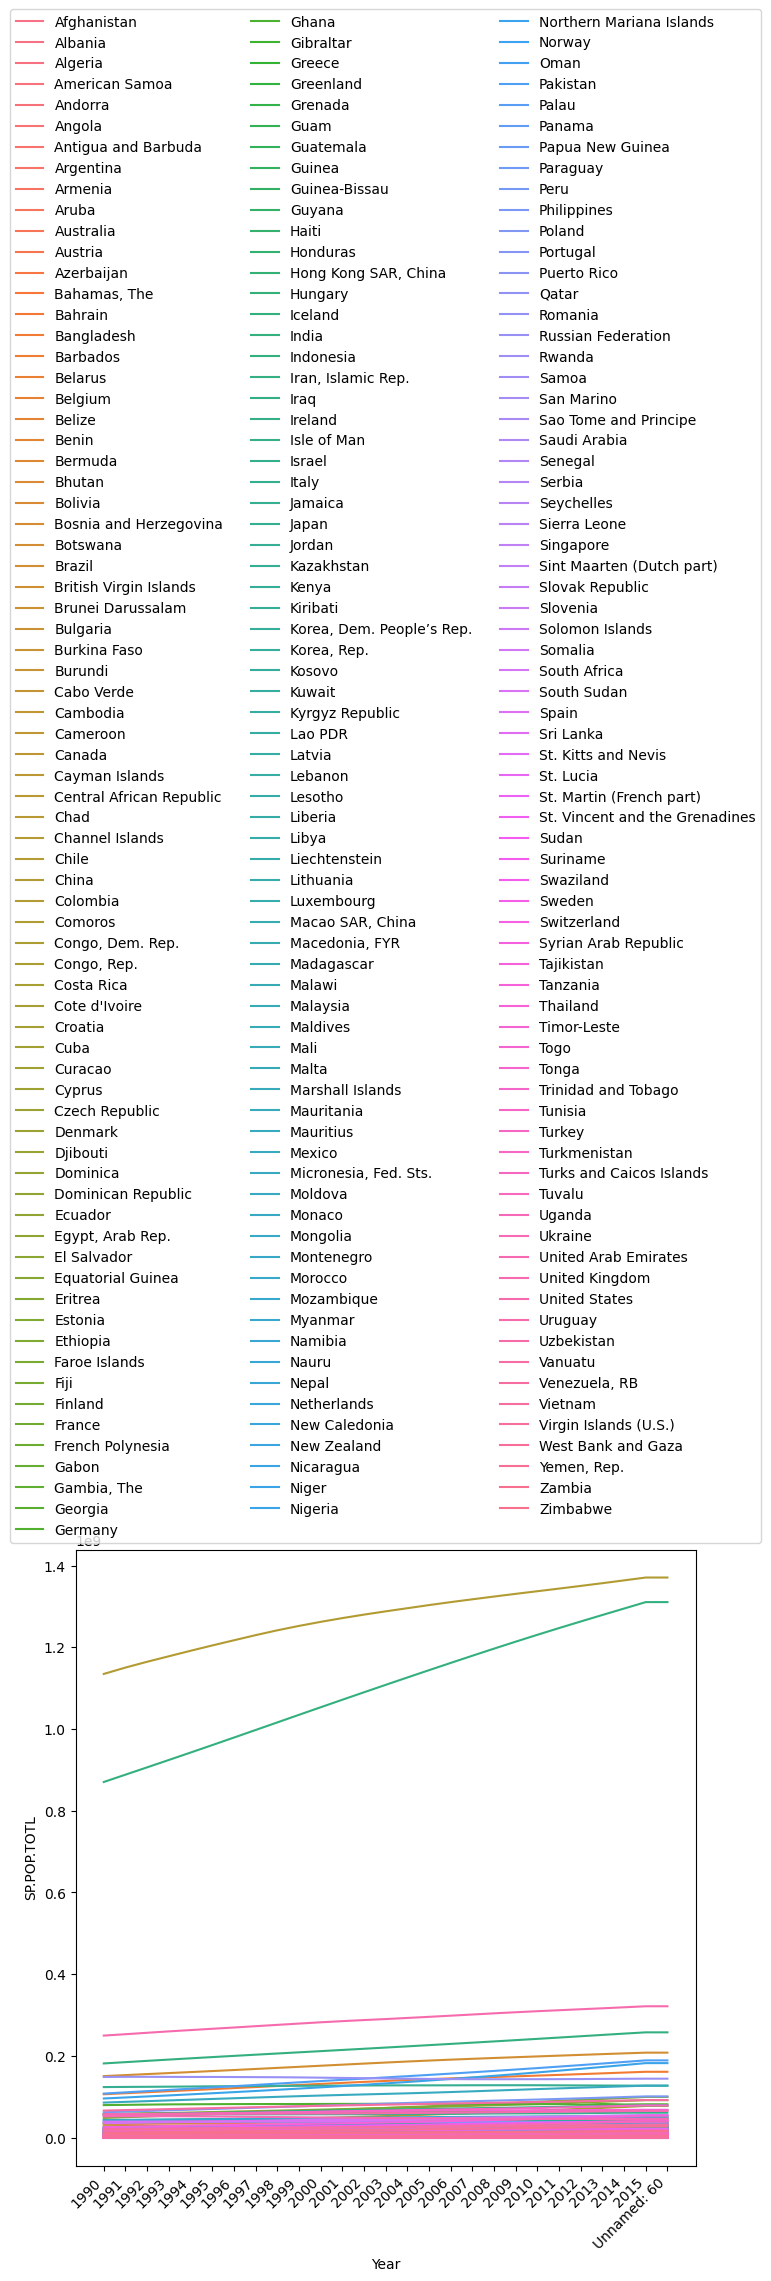

In [152]:
'''
for series in selected_kpi_list:
    print(series)
    plt.figure(figsize=(8, 8))
    sns.lineplot(data=df_x_1, x='Year', y=series, hue = 'Country Name')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3)
    plt.xticks(rotation=45, ha='right')
    # Add hover functionality
    cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)
    @cursor.connect("add")
    def on_add(sel):
        pass  # Do something with the selection
    plt.show()
    #plt.pause(5)
    #plt.close()
    break
'''

# Modeling

In [244]:
for item in kpi_dict.items():
    if 'Life' in item[1]:
        print(item)

('SP.DYN.LE00.FE.IN', 'Life expectancy at birth, female (years)')
('SP.DYN.LE00.MA.IN', 'Life expectancy at birth, male (years)')
('SP.DYN.LE00.IN', 'Life expectancy at birth, total (years)')
('SH.MMR.RISK.ZS', 'Lifetime risk of maternal death (%)')
('SH.MMR.RISK', 'Lifetime risk of maternal death (1 in: rate varies by country)')


In [245]:
'SP.DYN.LE00.IN' in df_x_1.columns

True

In [246]:
df_x_1 = df_x_1[df_x_1['Year'] != 'Unnamed: 60']
df_x_1['Year'] = df_x_1['Year'].astype('int')

In [247]:
df_x_1['Country Code'] = df_x_1['Country Name'].astype('category').cat.codes
df_x_1.drop('Country Name', axis=1, inplace=True)

In [248]:
df_x_1.head()

Indicator Code  Year SP.POP.TOTL SP.POP.GROW SP.URB.TOTL.IN.ZS SP.URB.TOTL  \
0               1990  12067570.0    3.879694            18.316   2210296.0   
1               1991  12789374.0    5.809298            18.597   2378440.0   
2               1992  13745630.0    7.210629            18.882   2595450.0   
3               1993  14824371.0    7.555156             19.17   2841832.0   
4               1994  15869967.0    6.815594            19.462   3088613.0   

Indicator Code SP.URB.GROW SP.RUR.TOTL.ZS SP.RUR.TOTL SP.RUR.TOTL.ZG  \
0                  5.40914         81.684   9857274.0       3.539933   
1                 7.331837         81.403  10410934.0       5.464694   
2                  8.73151         81.118  11150180.0       6.859904   
3                   9.0689          80.83  11982539.0       7.199487   
4                 8.327321         80.538  12781354.0       6.453688   

Indicator Code SP.POP.AG13.MA.IN  ... SP.DYN.IMRT.IN SH.DYN.MORT SH.DTH.MORT  \
0                       156249.0  ...          122.5       181.0    100437.0   
1                       166227.0  ...          118.3       174.2    101417.0   
2                       178695.0  ...          114.4       167.8    104899.0   
3                       192249.0  ...          110.9       162.0    109625.0   
4                       205445.0  ...          107.7       156.8    113758.0   

Indicator Code SH.DTH.IMRT SP.ADO.TFRT SP.DYN.TO65.FE.ZS SP.DYN.TO65.MA.ZS  \
0                  68718.0     162.738          44.99139          39.82877   
1                  69482.0     163.327          46.17192          40.92956   
2                  72376.0     163.916          47.35245          42.03034   
3                  76190.0    164.1812          48.09906          42.72012   
4                  79446.0    164.4464          48.84567          43.40989   

Indicator Code SP.DYN.AMRT.FE SP.DYN.AMRT.MA Country Code  
0                     348.006        396.086            0  
1                     339.753        387.388            0  
2                       331.5         378.69            0  
3                     326.244        373.408            0  
4                     320.988        368.125            0  

[5 rows x 170 columns]

In [249]:
y = df_x_1.drop('SP.DYN.LE00.IN', axis=1)
X = df_x_1

In [250]:
df_x_1.isna().any()

Indicator Code
Year                 False
SP.POP.TOTL          False
SP.POP.GROW          False
SP.URB.TOTL.IN.ZS    False
SP.URB.TOTL          False
                     ...  
SP.DYN.TO65.FE.ZS    False
SP.DYN.TO65.MA.ZS    False
SP.DYN.AMRT.FE       False
SP.DYN.AMRT.MA       False
Country Code         False
Length: 170, dtype: bool

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [254]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [257]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Instead of using 'selected_kpi_list', get the feature names directly from X_train
# This ensures the feature names match the importances array
feature_names = X_train.columns

# Create the DataFrame using the correct feature names
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)

print(feature_imp_df)

               Feature  Gini Importance
74   SP.POP.TOTL.MA.IN         0.055115
1          SP.POP.TOTL         0.044357
23   SP.POP.AG08.MA.IN         0.036391
130     SP.POP.0004.FE         0.035876
152     SP.POP.4044.FE         0.027955
..                 ...              ...
22   SP.POP.AG15.FE.IN         0.000013
96   SP.POP.1519.MA.5Y         0.000012
157  SP.DYN.LE00.MA.IN         0.000012
114  SP.POP.2529.MA.5Y         0.000010
169       Country Code         0.000003

[170 rows x 2 columns]


Mean Squared Error (MSE): 1571024456890.3494


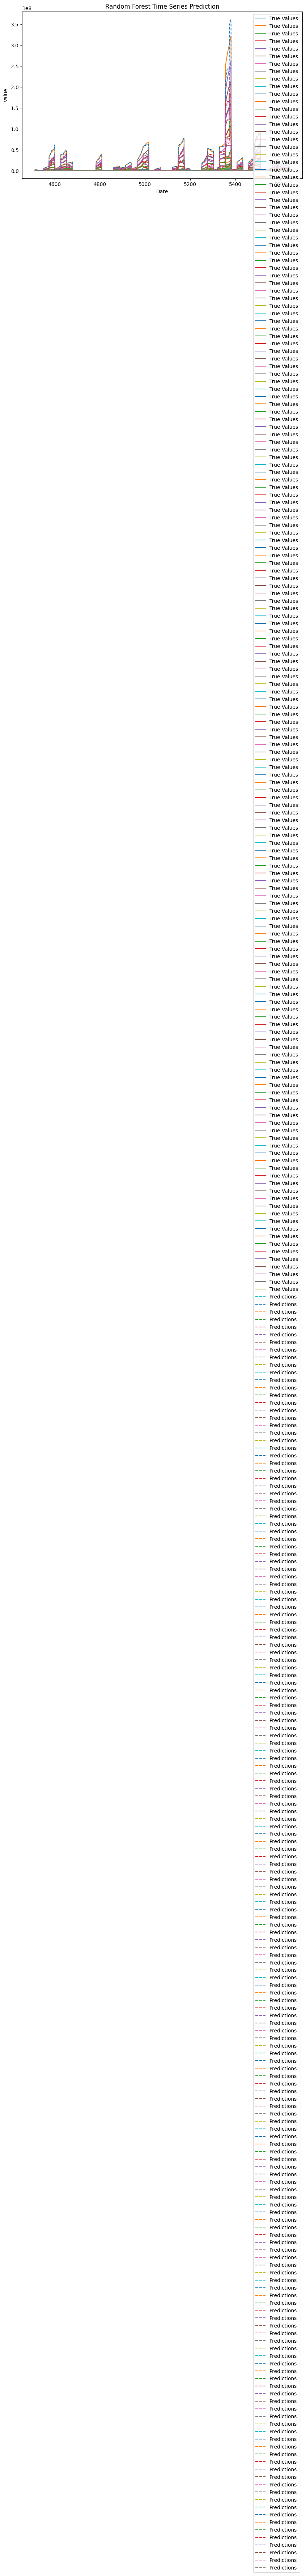

In [260]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_x_1.index[-len(y_test):], y_test, label='True Values')
plt.plot(df_x_1.index[-len(y_test):], y_pred, label='Predictions', linestyle='dashed')
plt.legend()
plt.title('Random Forest Time Series Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Observations



1.   Dataframe is wide.
2.   Not all year-country-indicator column is populated.
3.   Country Name includes both individual countries and conglomerates. Ex. Arab World.



# Considerations



1.   Consider to shift timeline
2.   Check the KPI column population per country to decide, consider a threshold where for a particular KPI, if x countries have populated data which is above the threshold, consider it.



# Research Questions

Which features affect "Life expectancy at birth, total (years)" across different regions and socio economic conditions ('High income', 'Middle income', 'Low & middle income', 'Lower middle income', 'Low income')?

# Exploratory Data Analysis - Matt

In [ ]:
pd.set_option('display.max_columns', None)
# health_df[health_df['Indicator Name'] == 'Literacy rate, youth total (% of people ages 15-24)'].info()

In [ ]:
income_range_df = health_df[health_df['Country Name'].isin(['High income', 'Low & middle income', ' Lower middle income', 'Low income', 'Middle income'])]
display(income_range_df.shape, income_range_df.head())

In [ ]:
ed_indicators = ['Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions)',
                'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)',
                'Literacy rate, adult female (% of females ages 15 and above)',
                'Literacy rate, adult male (% of males ages 15 and above)',
                'Literacy rate, adult total (% of people ages 15 and above)',
                'Literacy rate, youth male (% of males ages 15-24)',
                'Literacy rate, youth total (% of people ages 15-24)',
                'Primary completion rate, female (% of relevant age group)',
                'Primary completion rate, male (% of relevant age group)',
                'Primary completion rate, total (% of relevant age group)',
                'Public spending on education, total (% of GDP)',
                'Ratio of school attendance of orphans to school attendance of non-orphans ages 10-14',
                'Ratio of young literate females to males (% ages 15-24)',
                'School enrollment, primary (% gross)',
                'School enrollment, primary (% net)',
                'School enrollment, primary, female (% gross)',
                'School enrollment, primary, female (% net)',
                'School enrollment, primary, male (% gross)',
                'School enrollment, primary, male (% net)',
                'School enrollment, secondary (% gross)',
                'School enrollment, secondary (% net)',
                'School enrollment, secondary, female (% gross)',
                'School enrollment, secondary, female (% net)',
                'School enrollment, secondary, male (% gross)',
                'School enrollment, secondary, male (% net)',
                'School enrollment, tertiary (% gross)',
                'School enrollment, tertiary, female (% gross)']

In [ ]:
# set number of rows to display
pd.set_option('display.max_rows', 150)
# drop all columns prior to 1970
columns_to_drop = [str(year) for year in range(1960, 1970)]
# income_range_df = income_range_df.drop(columns=columns_to_drop)
ed_df = income_range_df[income_range_df['Indicator Name'].isin(ed_indicators)].drop(columns=['Country Code', 'Indicator Code'])
ed_df
li_ed_df = ed_df[ed_df['Country Name'] == 'Low income'].drop(columns=['2014', '2015', 'Unnamed: 60'])
li_ed_df

In [ ]:
li_lit_df = li_ed_df[li_ed_df['Indicator Name'].isin([
    'Literacy rate, adult female (% of females ages 15 and above)',
    'Literacy rate, adult male (% of males ages 15 and above)',
    'Literacy rate, adult total (% of people ages 15 and above)',
    'Literacy rate, youth male (% of males ages 15-24)',
    'Literacy rate, youth total (% of people ages 15-24)',
    'Literacy rate, youth female (% of females ages 15-24)'
])].dropna(axis=1).drop(columns='Country Name').set_index('Indicator Name')
li_lit_df

In [ ]:
df = li_lit_df.transpose()
df.plot(kind='line', figsize=(10, 4))
plt.xlabel('Year')
plt.ylabel('Literacy Rate (%)')
plt.title('Literacy Rates Over Time')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's look at formal education

In [ ]:
primary_completion_df = li_ed_df[li_ed_df['Indicator Name'].isin([
    'Primary completion rate, female (% of relevant age group)',
    'Primary completion rate, male (% of relevant age group)',
    'Primary completion rate, total (% of relevant age group)'
])].dropna(axis=1).drop(columns='Country Name').set_index('Indicator Name')
# primary_completion_df

In [ ]:
df = primary_completion_df.transpose()
df.plot(kind='line', figsize=(10, 4))
plt.title('Primary Completion Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Primary Completion Rate (%)')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
li_gni_df = health_df[health_df['Country Name'] == 'Low income']
li_gni_df = li_gni_df[li_gni_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)']
columns_to_drop = [str(year) for year in range(1960, 1988)]
li_gni_df = li_gni_df.drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60']).drop(columns=columns_to_drop)
li_gni_df.set_index('Indicator Name', inplace=True)
# li_gni_df

In [ ]:
li_gni_df = li_gni_df.transpose()
li_gni_df.plot(kind='line', figsize=(10, 4))
plt.title('GNI per Capita Over Time')
plt.xlabel('Year')
plt.ylabel('GNI per Capita')


In [ ]:
health_df[health_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)'].describe()

In [ ]:
health_indicators = ['Prevalence of anemia among children (% of children under 5)',
       'Prevalence of anemia among non-pregnant women (% of women ages 15-49)',
       'Prevalence of anemia among pregnant women (%)',
       'Prevalence of anemia among women of reproductive age (% of women ages 15-49)',
       'Prevalence of HIV, female (% ages 15-24)',
       'Prevalence of HIV, male (% ages 15-24)',
       'Prevalence of HIV, total (% of population ages 15-49)',
       'Prevalence of overweight (% of adults)',
       'Prevalence of overweight (% of children under 5)',
       'Prevalence of overweight, female (% of children under 5)',
       'Prevalence of overweight, female (% of female adults)',
       'Prevalence of overweight, male (% of children under 5)',
       'Prevalence of overweight, male (% of male adults)',
       'Prevalence of severe wasting, weight for height (% of children under 5)',
       'Prevalence of severe wasting, weight for height, female (% of children under 5)',
       'Prevalence of severe wasting, weight for height, male (% of children under 5)',
       'Prevalence of syphilis (% of women attending antenatal care)',
       'Prevalence of tuberculosis (per 100,000 population)',
       'Prevalence of undernourishment (% of population)',
       'Prevalence of wasting (% of children under 5)',
       'Prevalence of wasting, female (% of children under 5)',
       'Prevalence of wasting, male (% of children under 5)',
       'Malnutrition prevalence, height for age (% of children under 5)',
       'Malnutrition prevalence, height for age, female (% of children under 5)',
       'Malnutrition prevalence, height for age, male (% of children under 5)',
       'Malnutrition prevalence, weight for age (% of children under 5)',
       'Malnutrition prevalence, weight for age, female (% of children under 5)',
       'Malnutrition prevalence, weight for age, male (% of children under 5)',
       'Maternal leave benefits (% of wages paid in covered period)',
       'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
       'Maternal mortality ratio (national estimate, per 100,000 live births)',
       'Mortality caused by road traffic injury (per 100,000 people)',
       'Mortality rate, adult, female (per 1,000 female adults)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, infant, female (per 1,000 live births)',
       'Mortality rate, infant, male (per 1,000 live births)',
       'Mortality rate, neonatal (per 1,000 live births)',
       'Mortality rate, under-5 (per 1,000)',
       'Mortality rate, under-5, female (per 1,000)',
       'Mortality rate, under-5, male (per 1,000)']

In [ ]:
li_health_df = health_df[health_df['Indicator Name'].isin(health_indicators)][health_df['Country Name'] == 'Low income'].drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60'])
li_health_df

In [ ]:
# li_health_df.isna().sum()

In [ ]:
li_adult_mortality_df = li_health_df[li_health_df['Indicator Name'].isin(['Mortality rate, adult, female (per 1,000 female adults)',
                                                                          'Mortality rate, adult, male (per 1,000 male adults)'])]
li_adult_mortality_df



In [ ]:
li_adult_mortality_df = li_adult_mortality_df.set_index('Indicator Name').transpose()



In [ ]:
# rename index to "Year"
li_adult_mortality_df.index.name = 'Year'
li_adult_mortality_df

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4))
# add more space between plots
plt.subplots_adjust(hspace=0.5)

# plot adult mortality rate
axes[0][0].plot(li_adult_mortality_df.index, li_adult_mortality_df)
axes[0][0].set_title('Adult Mortality Rate by Year')
# only display xticks for every five years
axes[0][0].set_xticks(range(0, len(li_adult_mortality_df.index), 5))
axes[0][0].set_xticklabels(li_adult_mortality_df.index[::5])

# plot primary school completion rate
axes[0][1].plot(primary_completion_df.transpose().index, primary_completion_df.transpose())
axes[0][1].set_title('Primary School Completion Rate by Year')
axes[0][1].set_xticks(range(0, len(primary_completion_df.transpose().index), 5))
axes[0][1].set_xticklabels(primary_completion_df.transpose().index[::5])

# plot GNI per capita by year
axes[1][0].plot(li_gni_df.index, li_gni_df)
axes[1][0].set_title('GNI per Capita by Year')
axes[1][0].set_xticks(range(0, len(li_gni_df.index), 5))
axes[1][0].set_xticklabels(li_gni_df.index[::5])

# plot literacy rates over time
axes[1][1].plot(li_lit_df.transpose().index, li_lit_df.transpose())
axes[1][1].set_title('Literacy Rates by Year')


# Conclusions So Far
My hypothesis was that increasing education levels in low income countries might have a positive effect on life expectancy (or, as seen in the plots above, a decreasing effect on mortality rates). It seems clear, however, that at least in a broad sense, any effects of education are overshadowed by general wealth levels. That is to say, there's a definite correlation between education levels (as measured by primary school completion and literacy rates) and a decrease in adulkt mortality rates. However, GNI per capita seems to correlate even better with mortality rates than the chosen education metrics. (Note the dip and then plateau in GNI matches the brief rise in mortality rate from roughly 1990 to 2000.) This means we can't tell if education itself has anything to do with decreasing adult mortality rates, or if increased education and lower mortality rates are both effects of increasing wealth. Alternatively, it could be the case that education is the root cause of both decreasing mortality and increasing wealth.

As far as predictions go, this is not necessarily a problem. We could build a model to predict mortality rate that takes these factors (and others) into consideration. When it comes to elucidating causes and suggesting interventions, however, we want to know what has the most impact.

# Next Direction to Pursue
## Dig Deeper into the metrics
I suspect that the data I've examined so far will prove fairly representative, but I want to take a look at similar indicators to see if they follow the same patterns. I'll look at education indicators and health indicators in different categories - adult, youth - and in more specific areas, such HIV rates (which may correlate with sexual health education) and malaria incidence.

In [ ]:
reproductive_ed_indicators = [
    '% of females ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)',
    '% of males ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)'
    'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions',
    'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)',
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'Condom use with non regular partner, % adults(15-49), female',
    'Condom use with non regular partner, % adults(15-49), male',
    'Condom use, population ages 15-24, female (% of females ages 15-24)',
    'Condom use, population ages 15-24, male (% of males ages 15-24)',
    'Contraceptive prevalence, any methods (% of women ages 15-49)',
    'Contraceptive prevalence, modern methods (% of women ages 15-49)'
    ]
hiv_outcomes = [
    'Children (0-14) living with HIV',
    'Children (ages 0-14) newly infected with HIV',
    'Children orphaned by HIV/AIDS',
    'Prevalence of HIV, female (% ages 15-24)',
    'Prevalence of HIV, male (% ages 15-24)',
    'Prevalence of HIV, total (% of population ages 15-49)',
    'Adults (ages 15+) and children (0-14 years) living with HIV',
    'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
    'Adults (ages 15+) living with HIV',
    'Adults (ages 15+) newly infected with HIV'
    ]

In [ ]:
low_income_df = health_df[health_df['Country Name'] == 'Low income']
reproductive_ed_df = low_income_df[low_income_df['Indicator Name'].isin(reproductive_ed_indicators)].drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60'])
reproductive_ed_df

In [ ]:
reproductive_ed_df = reproductive_ed_df.dropna(axis=0, thresh=2)

In [ ]:
reproductive_ed_df

In [ ]:
reproductive_ed_df.set_index('Indicator Name').transpose().fillna(method='ffill').plot(kind='line', figsize=(10, 4))
plt.title('Reproductive Health Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')

In [ ]:
hiv_df = low_income_df[low_income_df['Indicator Name'].isin(hiv_outcomes)].drop(columns=['Country Code', 'Indicator Code', 'Country Name', 'Unnamed: 60'])
hiv_df

In [ ]:
hiv_df = hiv_df.set_index('Indicator Name').dropna(thresh=5).transpose().fillna(method='ffill')
hiv_df.plot(kind='line', figsize=(10, 4))
plt.title('HIV Outcomes Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')

# Reproductive Health
Here we see that higher contraceptive use, regardless of the specific method, is correlated with lower adolescent birth rates and lower prevalence of HIV over time.

Let's also look at:
* malaria
* spending on education
* education beyond primary
* separate countries that fall into low income level



In [ ]:
health_df[health_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)'].describe()

In [ ]:
gni_df = health_df[health_df['Indicator Name'] == 'GNI per capita, Atlas method (current US$)'].drop(columns=['Country Code', 'Indicator Code', 'Indicator Name', 'Unnamed: 60'])
gni_df

In [ ]:
# let's plot gni_df
gni_df.set_index('Country Name').transpose().plot(kind='line', figsize=(10, 4))
plt.title('GNI per Capita Over Time')
# no legend
plt.legend().set_visible(False)

That's not very informative...

# Let's Look at Individual Low-Income Countries
We'll create a threshold, based on an average of each country's GNI per capita over time, and examine the data and trends for all countries under that threshold.

In [ ]:
# let's find average gni for every Country Name in gni_df
gni_df[gni_df['Country Name'] == 'Low income']

In [ ]:
avg_gni = gni_df.bfill(axis=1)
avg_gni = avg_gni.set_index('Country Name')
avg_gni = avg_gni.ffill(axis=1).sort_values(by='Country Name')
avg_gni = avg_gni.ffill(axis=1).dropna()
avg_gni = avg_gni.mean(axis=1)
avg_gni.describe()

In [ ]:
avg_gni

I can use the info above to create my own list of low income countries and see if anything interesting shows up in the numbers for that group that is hidden in the aggregate view where country name = 'Low income'. Let's use the average value for the 'Low income' Country Name as our threshold, but let's bump it up a little bit to include a few more countries.

In [ ]:
avg_gni['Low income']

In [ ]:
threshhold = avg_gni['Low income'] + 150

In [ ]:
# build a custom list of low income countries
low_income_countries = avg_gni[avg_gni < threshhold].index.tolist()
low_income_countries.remove('Least developed countries: UN classification')  # remove the aggregate names
low_income_countries.remove('Low income')
low_income_countries.remove('Heavily indebted poor countries (HIPC)')
low_income_countries

In [ ]:
# filter the main df to include only those countries in the new list
new_df = health_df[health_df['Country Name'].isin(low_income_countries)]
new_df

In [ ]:
# build a df of education indicators for the low income countries
new_ed_df = new_df[new_df['Indicator Name'].isin(ed_indicators)]
# new_ed_df

In [ ]:
# new_ed_df.info()
# there's no non-null data in the columns 1960-1969, or in "unnamed", so let's drop those
new_ed_df = new_ed_df.drop(columns=['Country Code', 'Indicator Code']).dropna(axis=1, how='all')
# new_ed_df

In [ ]:
female_youth_hiv_ed_df = new_ed_df[new_ed_df['Indicator Name'] == 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, female (2 prevent ways and reject 3 misconceptions)'][['Country Name', '2005', '2006', '2010', '2014']].dropna(thresh=2)
# female_youth_hiv_ed_df
# 2005, 2006, 2010, 2014

In [ ]:
male_youth_hiv_ed_df = new_ed_df[new_ed_df['Indicator Name'] == 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)'][['Country Name', '2005', '2006', '2010', '2014']].dropna(thresh=2)
# male_youth_hiv_ed_df

In [ ]:
youth_hiv_ed_df = male_youth_hiv_ed_df.merge(female_youth_hiv_ed_df, how='outer', on="Country Name", suffixes=("_male", "_female"))
youth_hiv_ed_df

In [ ]:
big_hiv_df = new_df[new_df['Indicator Name'].isin(['Prevalence of HIV, female (% ages 15-24)', 'Prevalence of HIV, male (% ages 15-24)'])].dropna(thresh=5).drop(columns=['Country Code', 'Indicator Code']).dropna(axis=1, thresh=5)[['Country Name', '2005', '2006', '2010', '2014']].merge(youth_hiv_ed_df, how='inner', on="Country Name")

In [ ]:
df = new_df[new_df['Indicator Name'] == 'Prevalence of HIV, female (% ages 15-24)'][['Country Name', '2005', '2006', '2010', '2014']].merge(female_youth_hiv_ed_df, how='inner', on="Country Name", suffixes=('_hiv', '_ed')).dropna(axis=1, thresh=3)

In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
df_melted_hiv = df.melt(id_vars=['Country Name'], value_vars=['2005_hiv', '2006_hiv', '2010_hiv', '2014_hiv'],
                        var_name='Year', value_name='HIV')
df_melted_hiv['Year'] = df_melted_hiv['Year'].str.extract('(\d+)')

df_melted_ed = df.melt(id_vars=['Country Name'], value_vars=['2005_ed', '2006_ed', '2010_ed', '2014_ed'],
                       var_name='Year', value_name='Education')
df_melted_ed['Year'] = df_melted_ed['Year'].str.extract('(\d+)')

# Merge the two melted DataFrames
df_combined = pd.merge(df_melted_hiv, df_melted_ed, on=['Country Name', 'Year'])


In [ ]:
df_combined_cleaned = df_combined.dropna(subset=['HIV', 'Education'])

df_combined_cleaned

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot with all countries combined
plt.figure(figsize=(12, 8))
# sns.scatterplot(data=df_combined_cleaned, x="Education", y="HIV", hue="Country Name", palette="tab20", alpha=0.8)
sns.regplot(data=df_combined_cleaned, x="Education", y="HIV", scatter=True)

# Add labels and title
plt.title("Correlation Between Education and HIV Prevalence Across Countries", fontsize=16)
plt.xlabel("HIV Education Level (%)", fontsize=14)
plt.ylabel("HIV Prevalence (%)", fontsize=14)
# plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



In [ ]:
adult_lit = new_df[new_df['Indicator Name'] == 'Literacy rate, adult total (% of people ages 15 and above)']
adult_lit

In [ ]:
ed_indicators